# 주차수요 예측 AI 경진대회

그동안 공부한 내용을 바탕으로 직접 데이터를 다뤄보기 위해 데이콘 대회에 참여하였다. 대회 기간은 2021.06.10 ~ 2021.07.30 이었으며, 나는 7월 초 부터 참가하여 약 한달 정도 도전하였다. 참가한 대회는 한국토지주택공사와 데이콘이 함께한 [주차수요 예측 AI 경진대회](https://dacon.io/competitions/official/235745/overview/description)로 각 아파트 단지별로 등록차량수를 예측하는 문제이다.

데이터는 train, test, age_gender_info(지역별 성별 인구 비율) 3가지를 제공 받아 진행하였다. 데이콘은 하루 3번까지 test에 대한 예측값을 제출하여 그 중 일부에 대한 점수를 바로 확인 할 수 있어 이 점수를 토대로 수정을 거듭하면서 더 좋은 모델을 찾아 나갔다. 데이콘 게시판에서 베이스라인 코드(랜덤포레스트)를 공유해주었고 사람들끼리도 코드와 본인 의견을 올리기도 하여 여러모로 공부도 많이 되었다.

그동안 참가하면서 진짜 많은 시도도 해보았고 모델이 논리적으로 맞는지, 별개로 다양한 모델을 돌려보고 결과에 따라 이유가 무엇인지 고민을 많이 했던 것 같다. 한 달동안 워낙 많은 버전으로 제출을 하고 제때 정리하지 못했는데 그 중 일부에 대해 업로드 하려한다. 최종 제출버전 보다는 내가 고민했던 생각이나 시도해본 코드 위주로 적어두었다.

아래는 데이콘에서 제공한 자세한 대회 안내이다.

**[배경]**

아파트 단지 내 필요한 주차대수는 ①법정주차대수 ②장래주차수요 중 큰 값에 따라 결정하게되어 있어, 

정확한 ②장래주차수요의 산정을 필요로 합니다.

현재 ②장래주차수요는 ‘주차원단위’와 ‘건축연면적’을 기초로하여 산출되고 있으며, 

‘주차원단위’는 신규 건축예정 부지 인근의 유사 단지를 피크 시간대 방문하여 주차된 차량대수를 세는 방법으로 조사하고 있습니다.

이 경우 인력조사로 인한 오차발생, 현장조사 시점과 실제 건축시점과의 시간차 등의 문제로 과대 또는 과소 산정의 가능성을 배제할 수 없습니다.


**[주제]**

🏠 유형별 임대주택 설계 시 단지 내 적정 🅿️ 주차 수요를 예측

**[평가]**

평가산식 : MAE(Mean Absolute Error)

Public 평가 : 전체 Test 데이터 중 무작위 33% (50단지)

Private 평가 : 전체 Test 데이터 중 나머지 67% (100단지)


**기본 세팅**

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

import warnings

from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, PoissonRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from statsmodels.stats.outliers_influence import variance_inflation_factor

from pycaret.regression import *
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family='NanumGothic') # 폰트 설정
mpl.rc('axes', unicode_minus=False) # 유니코드에서 음수 부호 설정

# 차트 스타일 설정
sns.set(font="NanumGothic", rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc("figure", figsize=(10,8))

warnings.filterwarnings("ignore")

---

## 1.1 데이터 불러오기

In [3]:
# 데이터 불러오기
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
age_gender_info = pd.read_csv('age_gender_info.csv')

In [4]:
train_df.shape, test_df.shape

((2952, 15), (1022, 14))

In [5]:
train_df.head(3)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


In [6]:
test_df.head(3)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000,189840,0.0,2.0,683.0
1,C1072,754,아파트,경기도,국민임대,46.81,30,14.0,A,36048000,249930,0.0,2.0,683.0
2,C1072,754,아파트,경기도,국민임대,46.90,112,14.0,H,36048000,249930,0.0,2.0,683.0


- test에 없는 등록차량수를 예측하면 된다.

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2952 non-null   object 
 1   총세대수                          2952 non-null   int64  
 2   임대건물구분                        2952 non-null   object 
 3   지역                            2952 non-null   object 
 4   공급유형                          2952 non-null   object 
 5   전용면적                          2952 non-null   float64
 6   전용면적별세대수                      2952 non-null   int64  
 7   공가수                           2952 non-null   float64
 8   자격유형                          2952 non-null   object 
 9   임대보증금                         2383 non-null   object 
 10  임대료                           2383 non-null   object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2741 non-null   float64
 12  도보 10분거리 내 버스정류장 수            2948 non-null   float64
 13  단지내

In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          1022 non-null   object 
 1   총세대수                          1022 non-null   int64  
 2   임대건물구분                        1022 non-null   object 
 3   지역                            1022 non-null   object 
 4   공급유형                          1022 non-null   object 
 5   전용면적                          1022 non-null   float64
 6   전용면적별세대수                      1022 non-null   int64  
 7   공가수                           1022 non-null   float64
 8   자격유형                          1020 non-null   object 
 9   임대보증금                         842 non-null    object 
 10  임대료                           842 non-null    object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  980 non-null    float64
 12  도보 10분거리 내 버스정류장 수            1022 non-null   float64
 13  단지내

- 처음 데이터 구조를 확인하였을 때 train, test 모두 임대보증금, 임대료의 타입이 object로 입력되어 있었다.

In [9]:
# 컬럼명 변경
rename_col_lst = {"도보 10분거리 내 지하철역 수(환승노선 수 반영)": "지하철수",
                  "도보 10분거리 내 버스정류장 수": "버스수"}

train_df.rename(columns = rename_col_lst, inplace=True)
test_df.rename(columns = rename_col_lst, inplace=True)

- 우선 컬럼명이 너무 길어 지하철수, 버스수로 짧게 변경해두었다.

In [10]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
총세대수,2952.0,886.661247,513.540168,26.00,513.50,779.00,1106.0000,2568.0
전용면적,2952.0,44.757215,31.874280,12.62,32.10,39.93,51.5625,583.4
전용면적별세대수,2952.0,102.747967,132.640159,1.00,14.00,60.00,144.0000,1865.0
공가수,2952.0,12.921070,10.778831,0.00,4.00,11.00,20.0000,55.0
지하철수,2741.0,0.176578,0.427408,0.00,0.00,0.00,0.0000,3.0
버스수,2948.0,3.695726,2.644665,0.00,2.00,3.00,4.0000,20.0
단지내주차면수,2952.0,601.668360,396.407072,13.00,279.25,517.00,823.0000,1798.0
등록차량수,2952.0,559.768293,433.375027,13.00,220.00,487.00,770.0000,2550.0


- 처음 확인하였을 때 든 생각은 지하철수는 거의 다 0이었고 전용면적별세대수 평균이 중앙값보다 큰 것이 보였다.


- 이런 점 때문에 각 컬럼별로 왜곡도를 계산하여서 스케일링 할까? 생각하였던 것 같다.


- 이전에 [머신러닝 완벽가이드](https://romg2.github.io/mlguide/10_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C-05.-%ED%9A%8C%EA%B7%80-%EC%8B%A4%EC%8A%B5/#224-%ED%94%BC%EC%B2%98-%EB%A1%9C%EA%B7%B8-%EB%B3%80%ED%99%98)에서 비슷한 경험이 있어 이 점 부터 고려하였다.

In [11]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
총세대수,1022.0,862.080235,536.340894,75.00,488.000,745.00,1161.0,2572.0
전용면적,1022.0,43.706311,35.890759,9.96,33.135,39.72,47.4,583.4
전용면적별세대수,1022.0,100.414873,125.997855,1.00,14.000,60.00,140.0,1341.0
공가수,1022.0,15.544031,11.070140,0.00,6.000,15.00,23.0,45.0
지하철수,980.0,0.136735,0.435500,0.00,0.000,0.00,0.0,2.0
버스수,1022.0,4.626223,5.414568,1.00,2.000,3.00,5.0,50.0
단지내주차면수,1022.0,548.771037,342.636703,29.00,286.000,458.00,711.0,1696.0


- test에선 버스수가 50인 것이 눈에 띈다.

## 1.2 결측값 대체

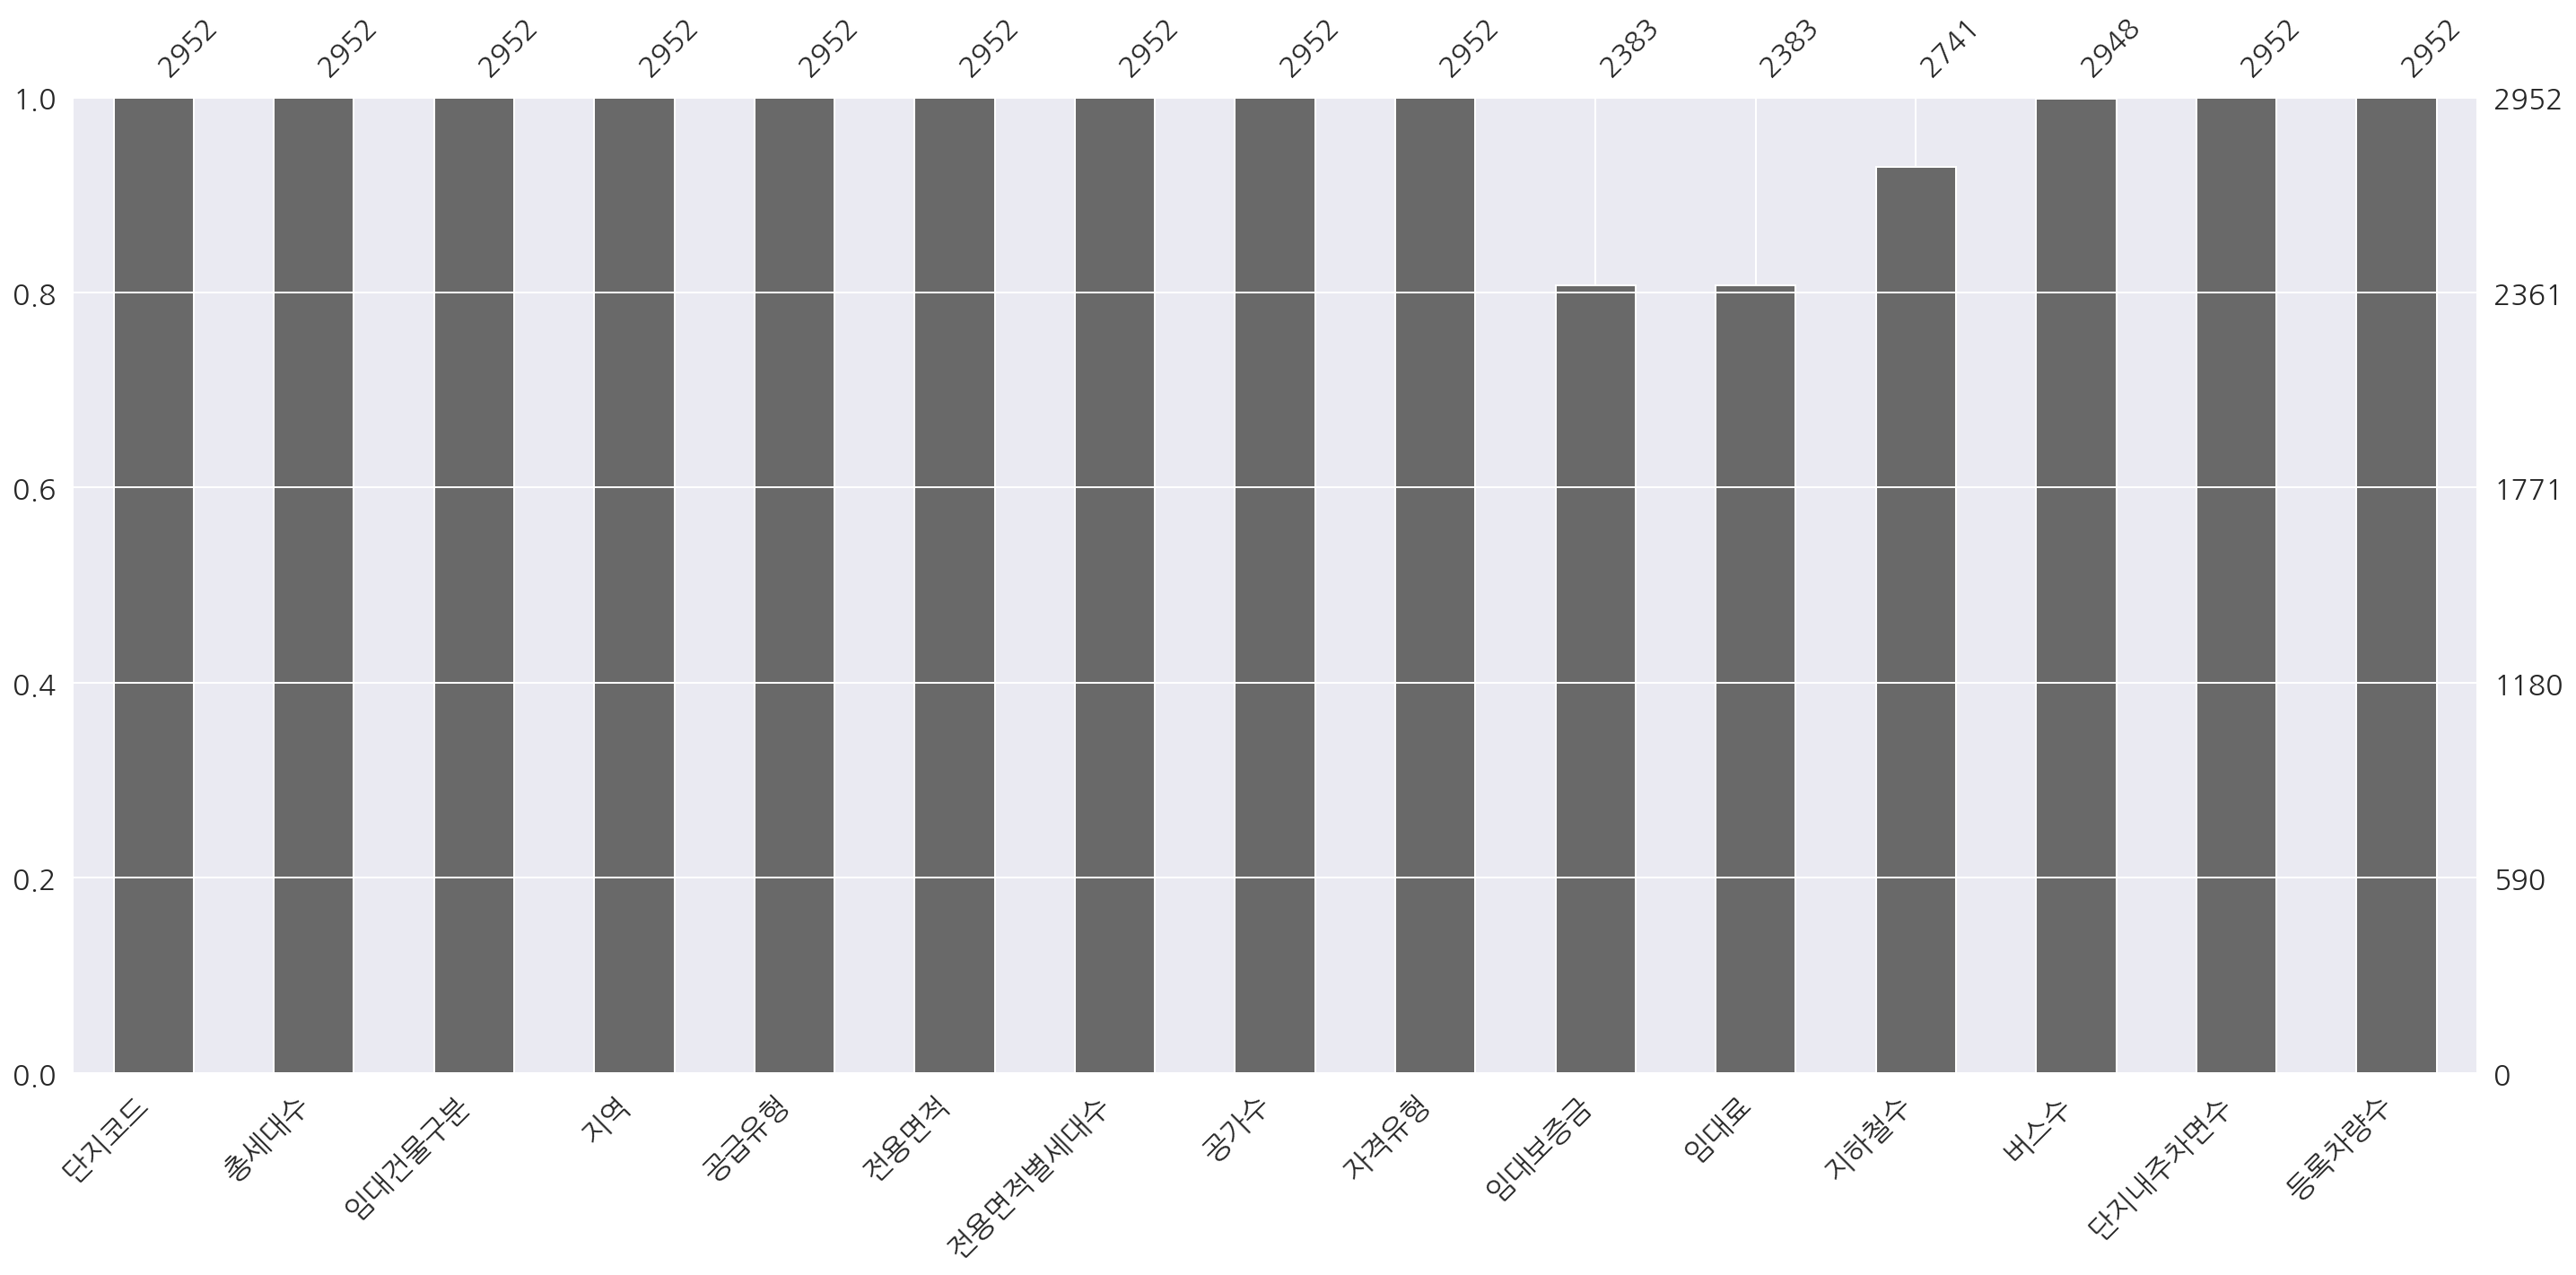

In [12]:
msno.bar(train_df)
plt.show()

- train은 `info`로 확인했듯이 임대보증금, 임대료, 지하철수, 버스수에 결측이 존재한다.

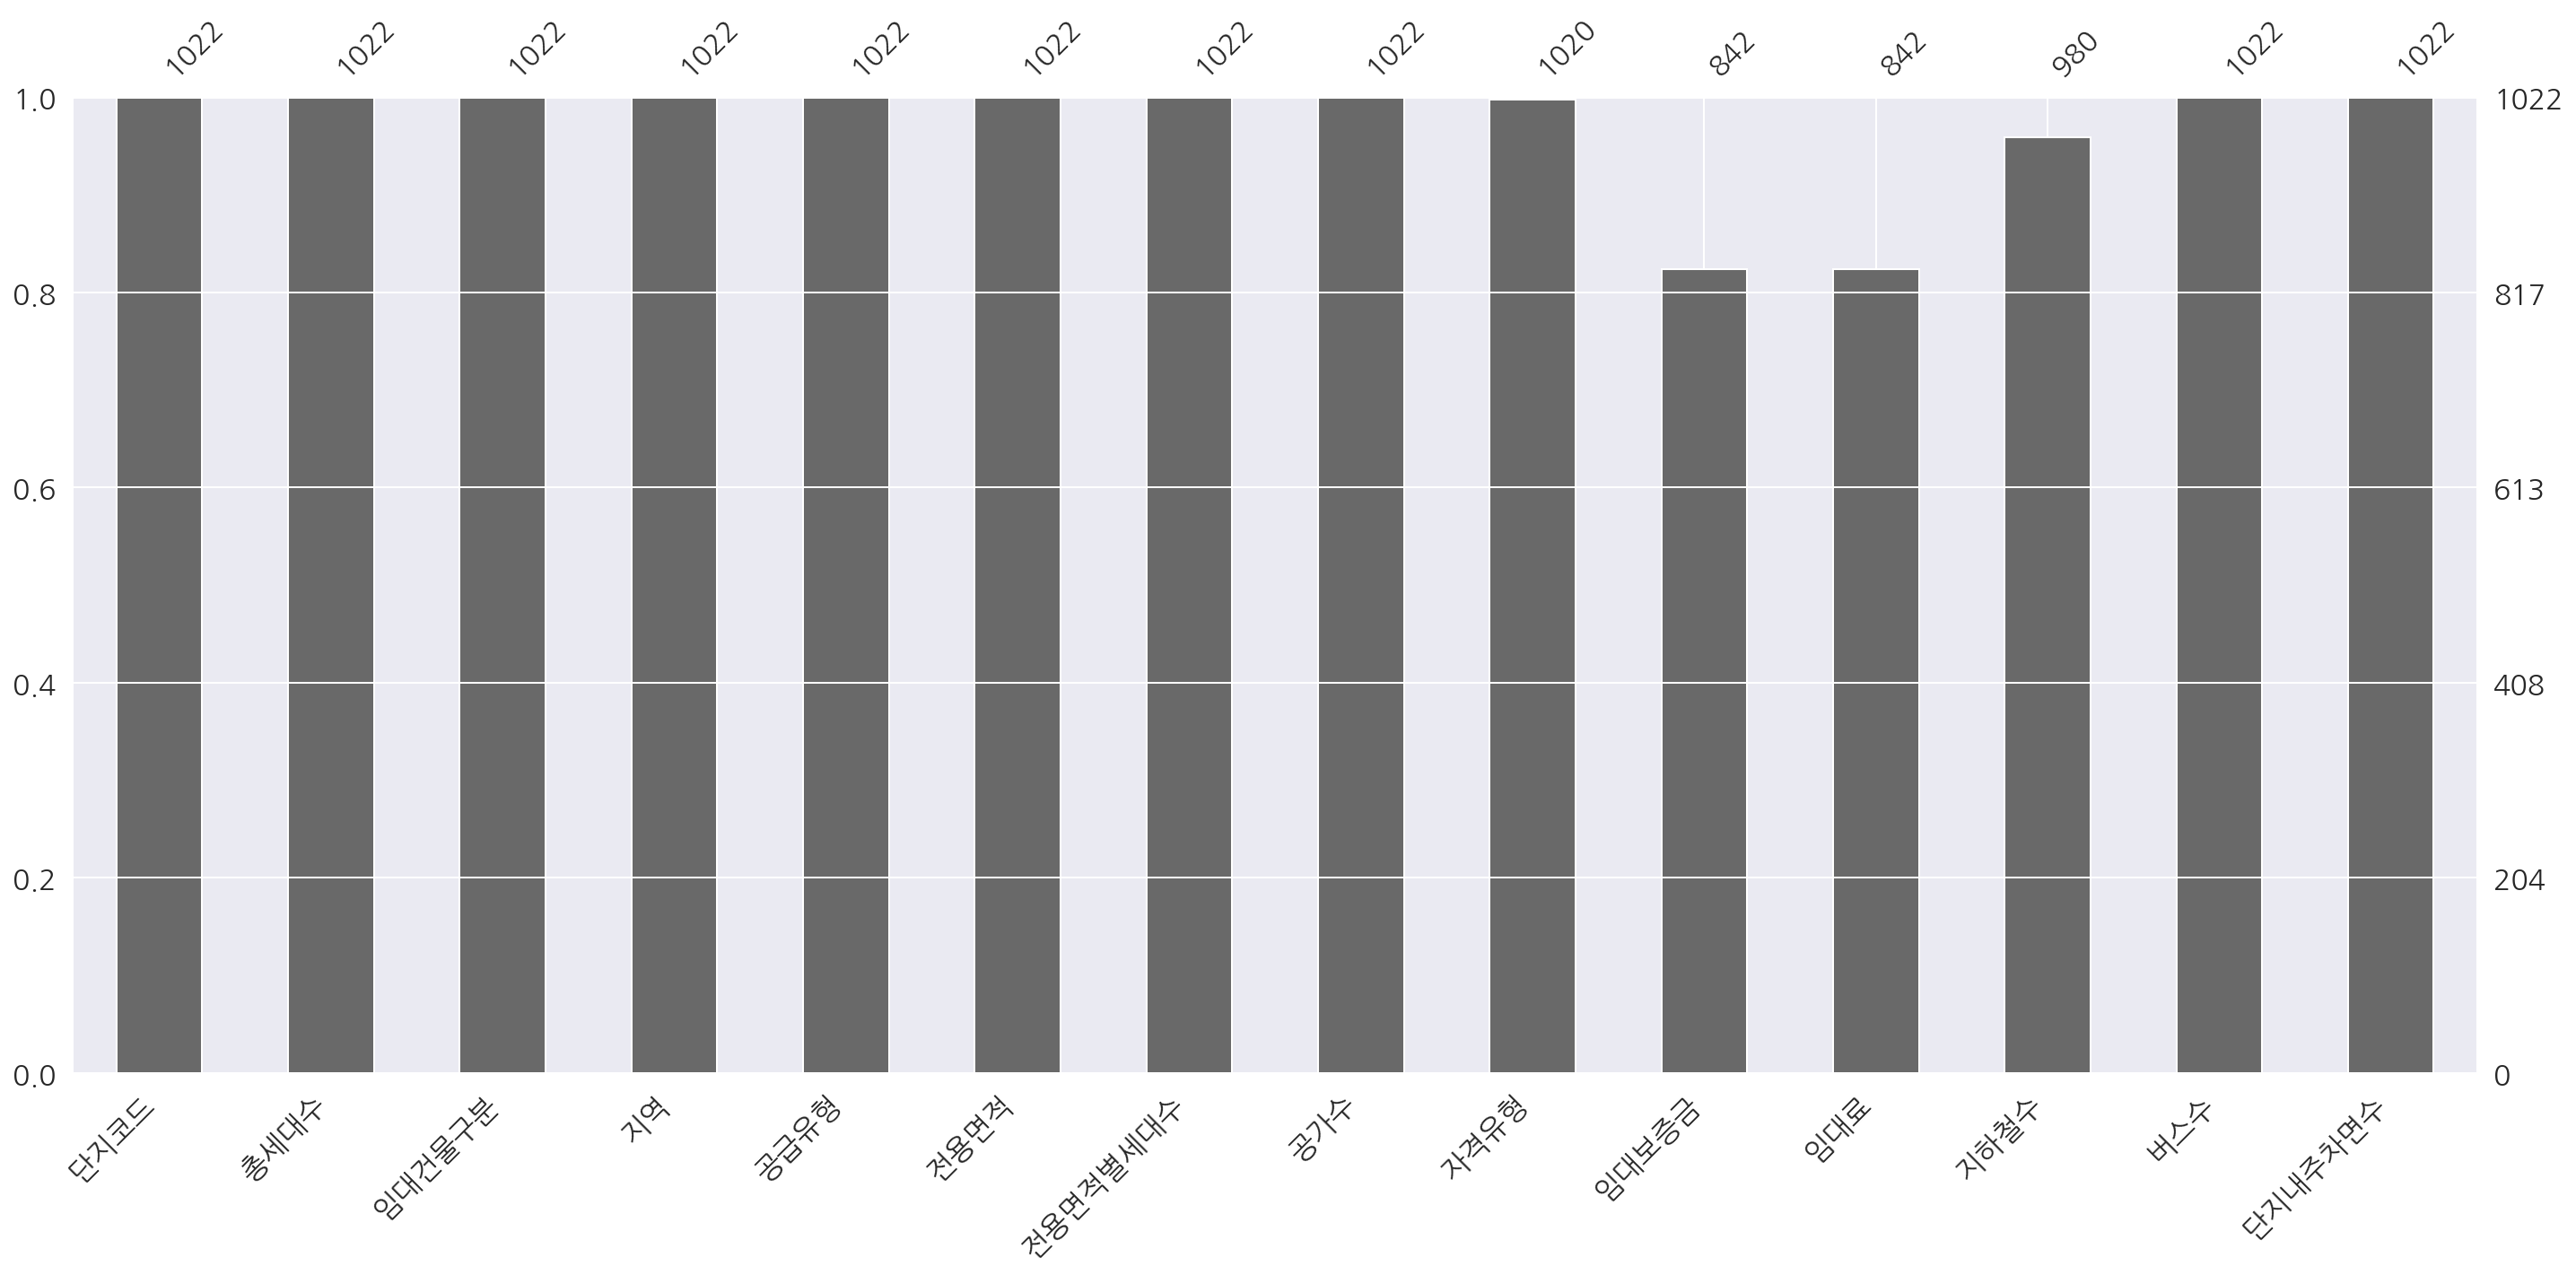

In [13]:
msno.bar(test_df)
plt.show()

- test는 `info()`로 확인했듯이 자격유형, 임대보증금, 임대료, 지하철수에 결측이 존재한다.

### 1.2.1 임대보증금, 임대료

In [14]:
# train["임대보증금"].value_counts().sort_index()
# train["임대료"].value_counts().sort_index()
# test["임대보증금"].value_counts().sort_index()
# test["임대료"].value_counts().sort_index()

# 임대보증금, 임대료 "-" 값, 결측값 0 으로 대체, int형으로 바꾸기
nan_lst = ["임대보증금","임대료"]

for column in nan_lst:
    train_df[column].replace("-", "0", inplace = True)
    train_df[column].fillna("0", inplace = True)
    train_df[column] = train_df[column].astype(int)
    
    test_df[column].replace("-", "0", inplace = True)
    test_df[column].fillna("0", inplace = True)
    test_df[column] = test_df[column].astype(int)

- 임대보증금, 임대료의 "-" 값, 결측값은 0으로 대체하였다.


- 자격유형별 임대보증금, 임대료의 평균이나 중앙값 대체도 고려하였으나 결국 최종버전에서도 0으로 대체하였다.


- 솔직히 주택 데이터에 대한 도메인이 부족하고 개념 공부에 시간을 많이 쏟지 못해 논리 없이 대체하기가 힘들었다.


- 다른 사람들도 대부분 0으로 대체하기도 하였다.

### 1.2.2 지하철수, 버스수

In [15]:
# train 지하철수, 버스수 결측값 0으로 대체
train_df["지하철수"].fillna(0, inplace = True)
train_df["버스수"].fillna(0, inplace = True)

# test 지하철수 결측값 0으로 대체
test_df["지하철수"].fillna(0, inplace = True)

- 지하철수, 버스수 결측값은 0으로 대체하였다.


- 지하철수는 train, test 합쳐서 0 ~ 3으로 나온다.


- float형이지만 평균값을 쓰는건 안 맞다고 생각하였고 train, test 둘 다 0이 중앙값이며 최빈값이었다.

### 1.2.3 자격유형

In [16]:
test_df[test_df["자격유형"].isnull()]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철수,버스수,단지내주차면수
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000,37470,0.0,2.0,840.0
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000,44770,0.0,2.0,173.0


- test의 자격유형이 결측인 건은 무엇으로 대체할지 고민되었다.


- 데이콘의 다른 분들의 의견을 참고하여 단지코드, 임대보증금, 임대료에 따라 자격유형을 확인해보았다.

In [17]:
temp = test_df.pivot_table("총세대수", ["단지코드","임대보증금","임대료"], "자격유형", aggfunc="count")
temp["자격유형종류"] = np.nan

for row in range(temp.shape[0]):
    not_nan = temp.iloc[row].notnull()
    value = str(list(not_nan[not_nan == True].index))
    
    temp.iloc[row, temp.shape[1]-1] = value
    

temp2 = temp.reset_index()[["단지코드","임대보증금","임대료","자격유형종류"]]
temp2.head()

자격유형,단지코드,임대보증금,임대료,자격유형종류
0,C1003,12000000,61000,['J']
1,C1003,18800000,96000,['J']
2,C1003,19600000,100000,['J']
3,C1003,25600000,131000,['J']
4,C1003,30000000,154000,['J']


In [18]:
temp2["자격유형종류"].value_counts()

['A']         310
['H']          46
['J']          41
['C']          19
['A', 'H']     10
['K']           7
['D']           7
['L']           6
['E']           6
['N']           5
['I']           5
['M']           1
['G']           1
Name: 자격유형종류, dtype: int64

- 위와 같은 방법으로 확인하였을 때 10건만 제외하고 한 가지 자격유형으로 분류되었다.

In [19]:
temp2[(temp2["단지코드"]=="C2411")]

자격유형,단지코드,임대보증금,임대료,자격유형종류
392,C2411,11992000,100720,['A']
393,C2411,21586000,171480,['A']


- 앞서 자격유형이 결측인 2건의 단지코드를 하나씩 확인하였다.


- C2411은 임대보증금, 임대료에 관계없이 자격유형이 A로 나타나 A로 대체하기로 하였다.

In [20]:
temp2[(temp2["단지코드"]=="C2253")]

자격유형,단지코드,임대보증금,임대료,자격유형종류
351,C2253,0,0,['D']
352,C2253,3731000,83020,['C']


- C2253은 임대보증금, 임대료가 0이면(즉, 원래 결측)이면 자격유형이 D, 아니면 C로 나타나 C로 대체하였다.

In [21]:
# test 자격유형 결측값 대체
test_df.loc[196, "자격유형"] = "A"
test_df.loc[258, "자격유형"] = "C"

print("train 결측 수:", train_df.isna().sum().sum())
print("test 결측 수:", test_df.isna().sum().sum())

train 결측 수: 0
test 결측 수: 0


- train, test 모두 결측 제거 완료되었다.

## 1.3 인코딩

결측 제거까지 완료된 후 문제는 최종적으로는 아파트 단지별로 등록차량수를 예측하여야 하는데 기존 데이터는 단지코드가 중복으로 들어가 있어 이를 단지코드 레벨로 수정할 필요가 있었다. 이 과정에서 원-핫 인코딩과 대표값 등을 어떻게 만들까 고민을 많이 했던 것 같다. 아래는 각 컬럼을 어떻게 처리할 지 당시에 생각하고 적어두었던 초기 고민을 그대로 가져왔다. 이전에 이미 데이터를 계속 확인해서 어느정도 상황을 파악하고 적어둔 내용이다.

- 임대건물구분: 원 핫 인코딩 주상복합 추가 후 원핫인코딩도 될 거 같음


- 공급유형: 일부 통합해서 쓰거나 일단 그대로 혹은 안쓰거나


- 전용면적: 구간 나눈 후 원핫인코딩 (이 건물이 전용면적이 특정 케이스가 있다. 의미니까)


- 전용면적별세대수: 전용면적이랑 같이써야는지


- 자격유형: 가장 빈도가 많은? (자격유형별 전용면적별세대수가 가장 많은 걸로) 혹은 가중치 


- 임대보증금 - 안씀 (전용면적별세대수 * 임대보증금 / 총세대수로?)


- 임대료 - 안씀 (전용면적별세대수 * 임대료 / 총세대수로?)


- 원-핫 인코딩시 train, test 모두 컬럼수가 동일해야한다.


- train만 있는 데이터라거나 test만 있는 데이터를 손봐야함

In [22]:
# 단지코드 레벨
level = train_df["단지코드"].nunique()
level

423

- train의 경우 단지코드의 중복을 제거하면 423으로 나타났다.

In [23]:
train_coldup = train_df.groupby(["단지코드"]).nunique()
train_coldup_cnt = train_coldup.sum()
train_coldup_cnt

총세대수         423
임대건물구분       456
지역           423
공급유형         488
전용면적        1898
전용면적별세대수    2230
공가수          423
자격유형         510
임대보증금       1277
임대료         1289
지하철수         423
버스수          423
단지내주차면수      423
등록차량수        423
dtype: int64

- 단지코드별로 중복이 없는 총세대수, 지역, 공가수, 지하철수, 버스수, 단지내주차면수, 등록차량수는 그대로 사용하기로 했다.

In [24]:
# 단지코드 레벨
level = train_df["단지코드"].nunique()

# 중복 없는 컬럼
no_dup_col = train_coldup_cnt[train_coldup_cnt == level].index.values

# 중복 있는 컬럼
dup_col = train_coldup_cnt[train_coldup_cnt != level].index.values

# 단지코드 레벨의 데이터 뼈대
new_train = train_df.drop_duplicates(no_dup_col).set_index("단지코드")[no_dup_col]
new_train = pd.get_dummies(new_train.sort_index())
new_train.head()

,총세대수,공가수,지하철수,버스수,단지내주차면수,등록차량수,지역_강원도,지역_경기도,지역_경상남도,지역_경상북도,지역_광주광역시,지역_대구광역시,지역_대전광역시,지역_부산광역시,지역_서울특별시,지역_세종특별자치시,지역_울산광역시,지역_전라남도,지역_전라북도,지역_제주특별자치도,지역_충청남도,지역_충청북도
단지코드,,,,,,,,,,,,,,,,,,,,,,
C1000,566,10.0,0.0,1.0,438.0,481.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
C1004,521,3.0,0.0,2.0,153.0,93.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
C1005,1144,16.0,0.0,8.0,950.0,376.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
C1013,1308,16.0,0.0,6.0,1119.0,1665.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
C1014,996,5.0,0.0,2.0,823.0,708.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


- 앞서 train을 확인한 코드는 test에 적용시 중복이 없는 컬럼은 동일하여 이를 함수로 나중에 생성하기로 생각했다.


- 추가로 test의 지역을 확인하였을 때 서울특별시가 없어 원 핫 인코딩을 어떻게 할지도 고민해야했다.


- 단순히 `pd.get_dummies()`를 사용하면 train과 test의 구조가 달라지기 때문에..

### 1.3.1 임대건물구분

In [25]:
print(train_df["임대건물구분"].unique())
print(test_df["임대건물구분"].unique())

['아파트' '상가']
['아파트' '상가']


- 첫 번째로 중복이 있는 임대건물구분은 아파트와 상가 2개의 값을 가지고 있다.

In [26]:
# 아파트, 상가, 주상복합으로 분리
def rental_class_apply(x):
    if (x["아파트"] > 0) & (x["상가"] > 0): return "주상복합"
    
    elif x["아파트"] > 0: return "아파트"
    
    else: return "상가"

def rental_class(df):
    # 단지코드, 임대건물구분별 count (값으로는 단지코드별로 같은 값을 가지는 총세대수 사용 큰 의미 없음)
    temp = df.pivot_table("총세대수", "단지코드", "임대건물구분", aggfunc="count").fillna(0)
    
    # 아파트, 상가, 주상복합으로 분리
    temp["건물"] = temp.apply(lambda x: rental_class_apply(x), axis=1)
    
    # 원-핫 인코딩
    rental =pd.get_dummies(temp[["건물"]])
    
    return rental

rental_class(train_df).head()

,건물_아파트,건물_주상복합
단지코드,,
C1000,1,0
C1004,0,1
C1005,1,0
C1013,1,0
C1014,1,0


- 원래는 아파트, 상가, 주상복합(아파트, 상가가 같이 있는 경우)로 구분하려 하였다.


- 확인해보니 상가를 가진 단지코드는 아파트도 무조건 가지고 있었다.


- 생각해보면 애초에 아파트 단지코드별로 주차수요를 예측하는데 아파트가 없는게 말이 안되지 싶었다...

### 1.3.2 전용면적, 전용면적별세대수

In [27]:
def area(df):
    # 전용면적을 5의 배수로
    temp = df.set_index("단지코드")["전용면적"]//5*5
    
    # 전용면적 상한 100, 하한 15로 설정
    temp[temp<15] = 15
    temp[temp>100]= 100
    
    return temp
    
print(np.sort(area(train_df).unique()))
print(np.sort(area(test_df).unique()))

[ 15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.  70.  75.  80.
 100.]
[ 15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  70.  75.  80. 100.]


- 위 코드는 데이콘 베이스라인에서 전용면적과 전용면적별 세대수를 전처리한 것을 확인해보려고 만들었다.


- 베이스라인은 전용면적을 5의 배수 구간으로 변경하였고 확인해보니 test에는 65 구간이 없었다.


- 이에 대해서 구간은 동일하게 하되 여러 방법을 생각해보았다.

**[방법 1]**

In [28]:
def area(df):
    # 전용면적 15~105까지 10단위로 9개 구간 생성
    bins = list(range(14,105,10))
    labels = [f"면적_{bins[i]+1}_{bins[i]+6}" for i in range(len(bins)-1)]

    # 전용면적을 5의 배수로
    temp = df.set_index("단지코드")["전용면적"]//5*5
    
    # 전용면적 상한 100, 하한 15로 설정
    temp[temp<15] = 15
    temp[temp>100]= 100
    
    # 면적구간 추가
    temp2 = temp.reset_index()
    temp2["면적구간"] = pd.cut(temp2["전용면적"], bins, labels=labels)
    
    # 단지코드별 면적구간 중복 제거
    temp3 = temp2.drop("전용면적", axis=1)
    temp3 = temp3.drop_duplicates()
    
    # 면적구간을 컬럼으로 할당하여 원-핫 인코딩 형태로 생성
    temp4 = temp3.assign(a=1)
    temp4 = temp4.pivot("단지코드","면적구간","a").fillna(0)
    
    # train, test 모두 없는 "면적_85_90" 구간 삭제, 컬럼 정렬
    labels.pop(-2)
    
    return temp4[labels]

area(train_df).head()

면적구간,면적_15_20,면적_25_30,면적_35_40,면적_45_50,면적_55_60,면적_65_70,면적_75_80,면적_95_100
단지코드,,,,,,,,
C1000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
C1004,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
C1005,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
C1013,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
C1014,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


- 방법1은 train과 test의 피처수가 동일하게끔 구간을 10단위로 설정하였다.


- 그리고 단지별로 특정 면적구간이 존재한다는 의미로 원-핫 인코딩을 실행하였다.

**[방법 2]**

In [29]:
def area2(df):
    # 전용면적 15~105까지 10단위로 9개 구간 생성
    bins = list(range(14,105,10))
    labels = [f"면적_{bins[i]+1}_{bins[i]+6}" for i in range(len(bins)-1)]

    # 전용면적을 5의 배수로
    temp = df.set_index("단지코드")["전용면적"]//5*5
    
    # 전용면적 상한 100, 하한 15로 설정
    temp[temp<15] = 15
    temp[temp>100]= 100
    
    # 면적구간 추가
    temp2 = temp.reset_index()
    temp2["면적구간"] = pd.cut(temp2["전용면적"], bins, labels=labels)
    temp2["전용면적별세대수"] = df["전용면적별세대수"]
    
    # 단지코드, 면적구간별 세대수 합
    temp3 = temp2.pivot_table("전용면적별세대수","단지코드","면적구간",aggfunc="sum").fillna(0)
    
    # train, test 모두 없는 "면적_85_90" 구간 삭제, 컬럼 정렬
    labels.pop(-2)
    
    return temp3[labels]

area2(train_df).head()

면적구간,면적_15_20,면적_25_30,면적_35_40,면적_45_50,면적_55_60,면적_65_70,면적_75_80,면적_95_100
단지코드,,,,,,,,
C1000,0.0,0.0,419.0,147.0,0.0,0.0,0.0,0.0
C1004,10.0,3.0,506.0,1.0,0.0,0.0,0.0,1.0
C1005,0.0,0.0,0.0,904.0,240.0,0.0,0.0,0.0
C1013,0.0,0.0,291.0,1017.0,0.0,0.0,0.0,0.0
C1014,0.0,516.0,0.0,396.0,84.0,0.0,0.0,0.0


- 방법2 역시 train과 test의 피처수가 동일하게끔 구간을 설정해 10단위로 묶었다.


- 그리고 단지별로 특정 면적구간의 세대수를 합하였다.


- 이 경우 추후 학습할 때 다중공선성 때문에 총 세대수는 넣으면 안될 것 같다고 생각하였다.

In [30]:
# 총 세대수와 전용면적별 세대수 합이 일치하지 않는다.
b = area2(train_df).sum(axis=1) - new_train.총세대수
len(b[b!=0])

40

- 이 과정에서 총 세대수와 전용면적별 세대수 합이 일치 하지 않는 것을 확인했다.


- 결론부터 말하면 추후 데이콘에서 담당자와 확인해 이 부분은 오류라고 감안하라고 하였다..;

**[방법 3]**

In [31]:
temp = train_df["전용면적"]//5*5
    
# 전용면적 상한 100, 하한 15로 설정
temp[temp<15] = 15
temp[temp>100]= 100

unique_col = np.sort(temp.unique())
unique_col

array([ 15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,  60.,  65.,
        70.,  75.,  80., 100.])

- 다음으론 구간을 5로 하되 train이 test보다 level이 많으므로 train 기준으로 전용면적 레벨을 추출한다.

In [32]:
def area3(df):
    # 전용면적을 5의 배수로
    temp = df.set_index("단지코드")["전용면적"]//5*5
    
    # 전용면적 상한 100, 하한 15로 설정
    temp[temp<15] = 15
    temp[temp>100]= 100
    
    # 단지코드별 전용면적 (중복 제거)
    temp2 = temp.reset_index().drop_duplicates()
    
    # 전용면적 값을 컬럼으로 사용    
    temp2[unique_col] = 0
    
    # 원-핫 인코딩 (전용면적값과 컬럼값이 동일하면 해당 컬럼에 1을 부여)
    for value in unique_col:
        col_idx = temp2["전용면적"] == value
        temp2.loc[col_idx, value] = 1
    
    temp2.drop("전용면적", inplace=True, axis=1)
    temp3 = temp2.groupby("단지코드").sum()
    
    # 컬럼명 수정
    col_name = [f"면적_{i}" for i in temp3.columns]
    temp3.columns = col_name
    
    return temp3

area3(train_df).head()

,면적_15.0,면적_20.0,면적_25.0,면적_30.0,면적_35.0,면적_40.0,면적_45.0,면적_50.0,면적_55.0,면적_60.0,면적_65.0,면적_70.0,면적_75.0,면적_80.0,면적_100.0
단지코드,,,,,,,,,,,,,,,
C1000,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0
C1004,1,1,1,1,1,0,0,1,0,0,0,0,0,0,1
C1005,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
C1013,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0
C1014,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0


- 방법3은 면적 컬럼을 베이스라인과 동일하게 설정하지만 방법1처럼 원-핫 인코딩 방식을 사용하였다.


- test는 65가 없어 모두 0으로 들어가게끔 원-핫 인코딩을 `pd.get_dummies()` 대신 직접 작성하였다.

**[방법 4]**

In [33]:
def area4(df):
    # 전용면적을 5의 배수로
    temp = df.set_index("단지코드")["전용면적"]//5*5
    
    # 전용면적 상한 100, 하한 15로 설정
    temp[temp<15] = 15
    temp[temp>100]= 100
    
    # 단지코드별 전용면적
    temp2 = temp.reset_index()
    temp2["전용면적별세대수"] = df["전용면적별세대수"]
    
    # 단지코드, 전용면적별 세대수 합
    temp3 = temp2.pivot_table("전용면적별세대수","단지코드","전용면적",aggfunc="sum").fillna(0)
    
    # 만약 unique_col에만 존재하는 컬럼이 있으면 값 0으로 컬럼 추가
    extra_col = list(set(unique_col) - set(temp3.columns.values))
    temp3[extra_col] = 0
    temp4 = temp3[unique_col]
    
    # 컬럼명 수정
    col_name = [f"면적_{i}" for i in temp4.columns]
    temp4.columns = col_name
    
    return temp4

area4(train_df).head()

,면적_15.0,면적_20.0,면적_25.0,면적_30.0,면적_35.0,면적_40.0,면적_45.0,면적_50.0,면적_55.0,면적_60.0,면적_65.0,면적_70.0,면적_75.0,면적_80.0,면적_100.0
단지코드,,,,,,,,,,,,,,,
C1000,0.0,0.0,0.0,0.0,419.0,0.0,72.0,75.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1004,3.0,7.0,1.0,2.0,506.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
C1005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,904.0,240.0,0.0,0.0,0.0,0.0,0.0,0.0
C1013,0.0,0.0,0.0,0.0,291.0,0.0,757.0,260.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1014,0.0,0.0,0.0,516.0,0.0,0.0,280.0,116.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0


- 방법4는 방법2와 방법3의 혼합 버전으로 전용면적 구간별(5단위)로 세대수의 합계를 구하는 방식으로 전처리 하였다.


- 사실 이 때 몰랐는데 결과물이 베이스라인과 완전 동일하였다.


- 베이스라인을 참고하더라도 코드는 직접 만든다는 생각에 베이스라인의 구간 아이디어만 참고했는데 똑같이 만들게 되었다.


- 결과물이 똑같으니 시간 날렸나 싶었는데 직접 고민하고 만든게 더 의미가 있지 않을까라고 생각한다...

### 1.3.3 공급유형

In [34]:
train_df["공급유형"].value_counts()

국민임대         1758
임대상가          562
행복주택          213
공공임대(10년)     205
영구임대          152
공공임대(50년)      31
공공임대(분납)       12
장기전세            9
공공분양            7
공공임대(5년)        3
Name: 공급유형, dtype: int64

In [35]:
test_df["공급유형"].value_counts()

국민임대         622
임대상가         177
행복주택         124
영구임대          45
공공임대(10년)     35
공공임대(50년)     13
공공임대(분납)       6
Name: 공급유형, dtype: int64

In [36]:
set(train_df["공급유형"].unique()) - set(test_df["공급유형"].unique())

{'공공분양', '공공임대(5년)', '장기전세'}

- train에는 공공분양, 공공임대(5년), 장기전세가 있으나 test는 없었다.


- 서울주택도시공사에서 임대주택 공급유형을 확인하였다.


- 이를 보고 우선 공공임대들이랑 공공분양은 공공임대로 묶으면 될 것 같다 생각하였다.


- 장기전세는 중산층이므로 그나마 성격이 가까워보이는 서민층인 국민임대랑 묶기로 하였다..

In [37]:
def supply_apply(x):
    if (x == "국민임대") | (x == "장기전세"):
        return "국민임대/장기전세"
    elif x.startswith("공공"):
        return "공공임대/분양"
    else:
        return x
    
def supply(df):
    temp = df[["단지코드"]]
    temp["공급유형"] = df["공급유형"].apply(lambda x: supply_apply(x))
    
    temp2 = temp.drop_duplicates().assign(temp_var=1)
    temp3 = temp2.pivot_table("temp_var","단지코드","공급유형",aggfunc="count").fillna(0)
    
    return temp3

supply(train_df).head()

공급유형,공공임대/분양,국민임대/장기전세,영구임대,임대상가,행복주택
단지코드,,,,,
C1000,0.0,1.0,0.0,0.0,0.0
C1004,0.0,0.0,1.0,1.0,0.0
C1005,0.0,1.0,0.0,0.0,0.0
C1013,0.0,1.0,0.0,0.0,0.0
C1014,0.0,1.0,0.0,0.0,0.0


- 앞서 지역이나 전용면적의 방법3,4 처럼 test에 없으면 모두 0으로 부여할까도 싶었다.


- 이 부분은 서울주택공사나 다른 사람들의 의견공유에서 묶는게 좋아보여 이렇게 결정하였다.

### 1.3.4 자격유형

In [38]:
train_df["자격유형"].unique()

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O'], dtype=object)

In [39]:
test_df["자격유형"].unique()

array(['H', 'A', 'E', 'C', 'D', 'G', 'I', 'J', 'K', 'L', 'M', 'N'],
      dtype=object)

In [40]:
set(train_df["자격유형"].unique()) - set(test_df["자격유형"].unique())

{'B', 'F', 'O'}

- 역시나 train에만 존재하는 자격유형이 있었다.

In [41]:
unique_col2 = train_df["자격유형"].unique()
unique_col2

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O'], dtype=object)

- 이 부분에 대해선 어떻게 묶어야 할지 모르겠어 test의 B, F, O는 0으로 처리하기로 하였다.

In [42]:
def qualification(df):
    temp = df[["단지코드","자격유형"]]
    temp = temp.drop_duplicates()

    temp[unique_col2]=0
    
    # 원-핫 인코딩 (자격유형값과 컬럼값이 동일하면 해당 컬럼에 1을 부여)
    for value in unique_col2:
        col_idx = temp["자격유형"] == value
        temp.loc[col_idx, value] = 1

    temp.drop("자격유형", inplace=True, axis=1)
    temp2 = temp.groupby("단지코드").sum()
    
    # 컬럼명 수정
    col_name = [f"자격_{i}" for i in temp2.columns]
    temp2.columns = col_name
    
    return temp2

qualification(train_df).head()

,자격_A,자격_B,자격_C,자격_D,자격_E,자격_F,자격_G,자격_H,자격_I,자격_J,자격_K,자격_L,자격_M,자격_N,자격_O
단지코드,,,,,,,,,,,,,,,
C1000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
C1004,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
C1005,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
C1013,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
C1014,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


- 여기까지 단지코드 레벨로 만들기 위한 사전 작업이 어느 정도 끝났다.


- 남은 것은 제공받은 데이터 중 age_gender_info를 사용하지 않았단 것과 1.3.2에서 확인한 오류 등이 있었다.

## 1.4 최종 전처리

1.1 ~ 1.3까지 초기에 데이터를 보고 생각한 점 위주로 작성하였다. 다만 대회를 진행하면서 여러 오류들이 발생되어 여러 수정사항이 발생하였다. 내가 발견한 오류 외에도 아래와 같은 사항이 있었다.

1. 전용면적별 세대수 합계와 총세대수가 일치하지 않는 경우


2. 동일한 단지에 단지코드가 2개로 부여된경우


3. 단지코드 등 기입 실수로 데이터 정제 과정에서 매칭 오류 발생

자세한 사항은 [여기](https://dacon.io/competitions/official/235745/talkboard/403708?page=1&dtype=recent)를 눌러 확인 가능하다.

아무튼 이러한 오류 때문에 전처리도 수정하였고 데이콘에선 1번 오류는 감안하고 2,3번 오류에 해당하는 단지코드는 제거하길 권유하였는데 3번 오류는 도저히 대체가 불가능해 보였고 안그래도 단지코드 레벨이 420개 가량인데 단지 코드를 제거하면 데이터가 너무 적은 것 같아 1,2번은 수정하는 방향으로 진행하였다. 이 과정에서 너무 여러 버전이 있어 최종 버전과 함께 설명을 적고자 한다.

In [43]:
# 데이터 불러오기
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
age_gender_info = pd.read_csv('age_gender_info.csv')

In [44]:
# 컬럼명 변경
rename_col_lst = {"도보 10분거리 내 지하철역 수(환승노선 수 반영)": "지하철수",
                  "도보 10분거리 내 버스정류장 수": "버스수"}

train_df.rename(columns = rename_col_lst, inplace=True)
test_df.rename(columns = rename_col_lst, inplace=True)

In [45]:
# 2번 오류 수정: 동일한 단지에 코드가 2개로 부여된 단지 코드

# test와 쌍을 이루는 경우가 있어 train에 해당 정보 추가
temp = test_df[test_df["단지코드"]=="C2675"]
temp["등록차량수"] = 1279
train_df = pd.concat([train_df, temp])
train_df = train_df.reset_index().drop(columns="index")

# ['C2085', 'C1397']
code = ['C2085', 'C1397']
# train_df[train_df["단지코드"].isin(code)]
err_idx = train_df[train_df["단지코드"].isin(code)].index.values

train_df.loc[err_idx, "단지코드"] = "C1397"
train_df.loc[err_idx, "총세대수"] = 1339
train_df.loc[err_idx, "공가수"] = 9

# ['C2431', 'C1649']
code = ['C2431', 'C1649']
err_idx2 = train_df[train_df["단지코드"].isin(code)].index.values

train_df.loc[err_idx2, "단지코드"] = "C1649"
train_df.loc[err_idx2, "총세대수"] = 1047
train_df.loc[err_idx2, "공가수"] = 31
train_df.loc[err_idx2, "지하철수"] = 0
train_df.loc[err_idx2, "버스수"] = 2
train_df.loc[err_idx2, "등록차량수"] = 1214

# ['C1036', 'C2675']
code = ['C1036', 'C2675'] 
err_idx3 = train_df[train_df["단지코드"].isin(code)].index.values

train_df.loc[err_idx3, "단지코드"] = "C1036"
train_df.loc[err_idx3, "총세대수"] = 1254
train_df.loc[err_idx3, "공가수"] = 22

# 확인
# code = ['C1397', 'C1649', 'C1036']
# train_df[train_df["단지코드"].isin(code)].sort_values(by="단지코드")

- 2번 오류의 경우는 같은 단지코드인데 다른 코드가 부여된 경우이므로 직접 뜯어본 후에 올바르게 수정하였다.


- 데이콘에서 총세대수, 등록차량수 등 올바른 값을 제공해주었고 나머지 다른 점은 unique한 값을 확인하였다.


- 처음에는 2번 오류도 제거하고 모델을 돌렸었는데 최종적으론 데이터를 잃지 않기 위해 수정하였다.

In [46]:
# train, test 제외 단지코드
# train_err_code = ['C2085', 'C1397', 'C2431', 'C1649', 'C1036', 'C1095','C2051','C1218','C1894','C2483','C1502','C1988'] 

# train: 3번 오류 삭제, test: 2번, 3번 오류 삭제
train_err_code = ['C1095','C2051','C1218','C1894','C2483','C1502','C1988'] 
test_err_code = ['C2675','C2335','C1327']

# 단지코드를 제외한 데이터
train = train_df[~train_df["단지코드"].isin(train_err_code)]
test = test_df[~test_df["단지코드"].isin(test_err_code)]

- 3번 오류는 직접 수정할 수 없어 제거하였다.

In [47]:
# 결측값 대체
# 임대보증금, 임대료 "-" 값, 결측값 0 으로 대체, int형으로 바꾸기
nan_lst = ["임대보증금","임대료"]

for column in nan_lst:
    train[column].replace("-", "0", inplace = True)
    train[column].fillna("0", inplace = True)
    train[column] = train[column].astype(int)
    
    test[column].replace("-", "0", inplace = True)
    test[column].fillna("0", inplace = True)
    test[column] = test[column].astype(int)
    
# train 지하철수, 버스수 결측값 0으로 대체
train["지하철수"].fillna(0, inplace = True)
#train["버스수"].fillna(0, inplace = True)

# test 지하철수 결측값 0으로 대체
test["지하철수"].fillna(0, inplace = True)

# test 자격유형 결측값 대체: 데이터 삭제후도 인덱스 번호 수정없어서 우선 이렇게 사용
test.loc[196, "자격유형"] = "A"
test.loc[258, "자격유형"] = "C"

print("train 결측 수:", train.isna().sum().sum())
print("test 결측 수:", test.isna().sum().sum())

train 결측 수: 0
test 결측 수: 0


- 결측값 대체는 초기와 동일하게 작성하였다.

### 1.4.1 기본 토대 

In [48]:
# 단지코드 레벨의 데이터 뼈대함수
def new_df(df):
    # 단지코드별 각 컬럼 중복 제외 수
    df_coldup = df.groupby(["단지코드"]).nunique()
    df_coldup_cnt = df_coldup.sum()
    df_coldup_cnt

    # 단지코드 레벨
    level = df["단지코드"].nunique()

    # 중복 없는 컬럼
    no_dup_col = df_coldup_cnt[df_coldup_cnt == level].index.values

    # 중복 있는 컬럼
    dup_col = df_coldup_cnt[df_coldup_cnt != level].index.values

    # 단지코드 레벨의 데이터 뼈대
    new_df = df.drop_duplicates(no_dup_col).set_index("단지코드")[no_dup_col]
    new_df = new_df.reset_index()
      
    new_df2 = pd.merge(new_df,age_gender_info, on="지역").set_index("단지코드")
    
    new_df3 = pd.get_dummies(new_df2.sort_index())
    
    return new_df3

- 지역 임대주택 나이별, 성별 인구 분포를 추가한 뼈대 데이터 생성함수를 정의하였다.

In [49]:
new_train, new_test = new_df(train), new_df(test)

# target은 분리
target = new_train["등록차량수"]
new_train.drop("등록차량수", inplace=True, axis=1)

# test에는 없는 지역_서울특별시는 모두 0으로 설정 - 컬럼 순서 train과 같게
new_test["지역_서울특별시"]=0
new_test = new_test[new_train.columns.values]

In [50]:
new_train.head(1)

,총세대수,공가수,지하철수,버스수,단지내주차면수,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),40대(남자),50대(여자),50대(남자),60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자),지역_강원도,지역_경기도,지역_경상남도,지역_경상북도,지역_광주광역시,지역_대구광역시,지역_대전광역시,지역_부산광역시,지역_서울특별시,지역_세종특별자치시,지역_울산광역시,지역_전라남도,지역_전라북도,지역_제주특별자치도,지역_충청남도,지역_충청북도
단지코드,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C1000,566,10.0,0.0,1.0,438.0,0.034678,0.035339,0.059808,0.06157,0.060824,0.064937,0.061069,0.056625,0.082318,0.072648,0.082747,0.074276,0.07539,0.062427,0.041814,0.027566,0.027762,0.011212,0.005386,0.00131,0.000257,0.000037,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [51]:
# train, test 모두 단지코드 레벨로 핸들링 완료
print(new_train.shape)
print(new_test.shape)

(414, 43)
(147, 43)


### 1.4.2 임대건물구분

In [52]:
# 아파트, 상가, 주상복합으로 분리
def rental_class_apply(x):
    if (x["아파트"] > 0) & (x["상가"] > 0): return "주상복합"
    
    elif x["아파트"] > 0: return "아파트"
    
    else: return "상가"

def rental_class(df):
    # 단지코드, 임대건물구분별 count (값으로는 단지코드별로 같은 값을 가지는 총세대수 사용 큰 의미 없음)
    temp = df.pivot_table("총세대수", "단지코드", "임대건물구분", aggfunc="count").fillna(0)
    
    # 아파트, 상가, 주상복합으로 분리
    temp["건물"] = temp.apply(lambda x: rental_class_apply(x), axis=1)
    
    # 원-핫 인코딩
    rental = pd.get_dummies(temp[["건물"]])
    
    return rental

- 임대건물구분은 초기버전과 같이 원-핫 인코딩을 선택하였다.

### 1.4.3 면적, 세대수

In [53]:
# 전용면적을 5의 배수로
temp = train["전용면적"]//5*5
    
# 전용면적 상한 100, 하한 15로 설정
temp[temp<15] = 15
temp[temp>100]= 100

# train의 전용면적 레벨
unique_col = np.sort(temp.unique())

def area4(df):
    # 전용면적을 5의 배수로
    temp = df.set_index("단지코드")["전용면적"]//5*5
    
    # 전용면적 상한 100, 하한 15로 설정
    temp[temp<15] = 15
    temp[temp>100]= 100
    
    # 단지코드별 전용면적
    temp2 = temp.reset_index()
    temp2["전용면적별세대수"] = df["전용면적별세대수"].values
    
    # 단지코드, 전용면적별 세대수 합
    temp3 = temp2.pivot_table("전용면적별세대수","단지코드","전용면적",aggfunc="sum").fillna(0)
    
    # 만약 unique_col에만 존재하는 컬럼이 있으면 값 0으로 컬럼 추가
    extra_col = list(set(unique_col) - set(temp3.columns.values))
    temp3[extra_col] = 0
    temp4 = temp3[unique_col]
    
    # 컬럼명 수정
    col_name = [f"면적_{int(i)}" for i in temp4.columns]
    temp4.columns = col_name
    
    return temp4

In [54]:
# 1번 오류 수정
def area5(df):
    temp = area4(df)
    temp2 = pd.DataFrame()
    
    for col in temp.columns:
        temp2[col] = temp.apply(lambda x: x[col] /np.sum(x), axis=1) * new_df(df)["총세대수"]
    
    return temp2

- 최종적으론 초기 고민했던 방법 중 방법4를 선택하였고 1번 오류를 수정하기 위해 조금 더 손보았다.


- 면적별 세대수 합계와 총세대수가 일치하지 않는 경우 총세대수 x 면적별 세대수 비율로 만드는 방식을 채택하였다.


- 실제로 당시에 이 부분을 수정하고 제출 결과에서 예측 성능이 같은 모델임에도 좋아졌었다.

### 1.4.4 공급유형

In [55]:
def supply_apply(x):
    if (x == "국민임대") | (x == "장기전세"):
        return "국민임대_장기전세"
    elif x.startswith("공공"):
        return "공공임대_분양"
    else:
        return x
    
def supply(df):
    temp = df[["단지코드"]]
    temp["공급유형"] = df["공급유형"].apply(lambda x: supply_apply(x))
    
    temp2 = temp.drop_duplicates().assign(temp_var=1)
    temp3 = temp2.pivot_table("temp_var","단지코드","공급유형",aggfunc="count").fillna(0)
    
    return temp3

- 공급유형도 기존에 일부를 묶어 원-핫 인코딩을 선택하였다.

### 1.4.5 자격유형

In [56]:
train.loc[train.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'
test.loc[test.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'

train.loc[train.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대_장기전세_공급대상'
test.loc[test.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대_장기전세_공급대상'

train.loc[train.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'
test.loc[test.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'

# train의 자격유형 레벨
unique_col2 = train["자격유형"].unique()

def qualification(df):
    temp = df[["단지코드","자격유형"]]
    temp = temp.drop_duplicates()

    temp[unique_col2]=0
    
    # 원-핫 인코딩 (자격유형값과 컬럼값이 동일하면 해당 컬럼에 1을 부여)
    for value in unique_col2:
        col_idx = temp["자격유형"] == value
        temp.loc[col_idx, value] = 1

    temp.drop("자격유형", inplace=True, axis=1)
    temp2 = temp.groupby("단지코드").sum()
    
    # 컬럼명 수정
    col_name = [f"자격_{i}" for i in temp2.columns]
    temp2.columns = col_name
    
    return temp2

- 자격 유형의 경우 사실 초기 버전을 많이 사용하였다가 다른 분의 [코드 공유](https://dacon.io/competitions/official/235745/codeshare/2851?page=1&dtype=recent)를 보고 거의 마지막에 수정하였다.


- 많이 조사하시고 논리를 정해서 전처리 한 것을 보고 대단하다고 생각이 들었다.

### 1.4.6 임대보증금, 임대료

In [57]:
def rental_cost(df):
    temp = df.groupby("단지코드").mean()[["임대보증금","임대료"]]
    return temp

- 추가로 임대보증금과 임대료에 대해 평균값을 사용할까 싶어 생성해두었다.

### 1.4.7 최종 결합

In [58]:
# 전용면적을 5의 배수로
temp = train["전용면적"]//5*5
    
# 전용면적 상한 100, 하한 15로 설정
temp[temp<15] = 15
temp[temp>100]= 100

# train의 전용면적, 자격유형 레벨
unique_col = np.sort(temp.unique())
unique_col2 = train["자격유형"].unique()

# 각 피처 인코딩 결과 합쳐주기
def final_df(df, new_df):
    rental_df = rental_class(df)
    area_df = area5(df)
    supply_df = supply(df)
    qualification_df = qualification(df)
    rental_cost_df = rental_cost(df)
    
    # 뼈대 데이터, 모든 함수들 다 단지코드를 index로 정렬되어있으므로 pd.concat 사용
    final_df = pd.concat([new_df, rental_df, area_df, supply_df, qualification_df], axis=1)
    
    return final_df

final_train, final_test = final_df(train, new_train), final_df(test, new_test)
final_train["등록차량수"] = target

- 임대 보증금과 임대료 평균도 사용할거면 `pd.concat()`에 추가하기로 하고 제외 해두었다.


- 아무래도 결측값 대체를 0으로 한 것도 많아 그냥 사용하기가 힘들어 보였다.


- 이 다음 과정들은 내가 생각한 논리에 따라 피처를 제거하기도 하고 스케일링 하면서 모델을 제출할 때 마다 수정하였다.

#### 1.4.7.1 피처 제거

In [59]:
# # 지역별 성별나이별 비율 
# drop_col = ['10대미만(여자)', '10대미만(남자)','10대(여자)', '10대(남자)', '20대(여자)', 
#             '20대(남자)', '30대(여자)', '30대(남자)','40대(여자)', '40대(남자)', '50대(여자)', 
#             '50대(남자)', '60대(여자)', '60대(남자)','70대(여자)', '70대(남자)', '80대(여자)', 
#             '80대(남자)', '90대(여자)', '90대(남자)','100대(여자)', '100대(남자)']

# final_train = final_train.drop(columns = drop_col)
# final_test = final_test.drop(columns = drop_col)

# # 지역 원-핫 인코딩
# drop_col2 = ['지역_강원도', '지역_경기도', '지역_경상남도', '지역_경상북도', '지역_광주광역시', 
#              '지역_대구광역시', '지역_대전광역시', '지역_부산광역시', '지역_서울특별시', '지역_세종특별자치시', 
#              '지역_울산광역시', '지역_전라남도', '지역_전라북도', '지역_제주특별자치도', '지역_충청남도', '지역_충청북도']


# final_train = final_train.drop(columns = drop_col2)
# final_test = final_test.drop(columns = drop_col2)

# 총 세대수
# drop_col3 = ['총세대수']

# final_train = final_train.drop(columns = drop_col3)
# final_test = final_test.drop(columns = drop_col3)

# # 면적별 세대수
# drop_col4 = ['면적_15', '면적_20', '면적_25','면적_30', '면적_35', '면적_40', '면적_45', '면적_50', '면적_55','면적_60', '면적_65', '면적_70', '면적_75', '면적_80', '면적_100']

# final_train = final_train.drop(columns = drop_col4)
# final_test = final_test.drop(columns = drop_col4)

- 우선 지역별 성별 나이별 비율이 말 그대로 "지역"에 대한 수치이므로 큰 의미가 있을까 싶었다.


- 지역 원-핫 인코딩은 모델을 제출하면서 결과가 딱히 좋지 않아 고민하였었다.


- 총 세대수와 면적별 세대수는 다중공선성이 문제가 될 것 같아 둘 중 하나를 제거하는 방식을 생각하였었다.

#### 1.4.7.2 타겟 추가

In [60]:
# # train 단지내주차면수 구간별 등록차량수 집계치
# temp = final_train.copy()
# temp["주차면수그룹"] = pd.cut(temp["단지내주차면수"], 9, labels=range(9))
# temp["target"] = target
# temp2 = temp.groupby("주차면수그룹").agg({"단지내주차면수":["min","max","count"],"target":["mean","median"]})

# # 필요 변수
# criteria = temp2[('단지내주차면수','max')]
# target_mean  = temp2[('target','mean')]
# target_median  = temp2[('target','median')]

# def target_add(x, mean=True):
#     # 평균값, 중앙값 중 결정
#     if mean == True: return_value = target_mean
#     else: return_value = target_median
    
#     # train 단지내주차면수 구간별 등록차량수 집계치 return
#     if x <= criteria[0]: return return_value[0]
#     elif x <= criteria[1]: return return_value[1]
#     elif x <= criteria[2]: return return_value[2]
#     elif x <= criteria[3]: return return_value[3]
#     elif x <= criteria[4]: return return_value[4]
#     elif x <= criteria[5]: return return_value[5]
#     elif x <= criteria[6]: return return_value[6]
#     elif x <= criteria[7]: return return_value[7]
#     elif x <= criteria[8]: return return_value[8]

In [61]:
# # 평균값 추가
# # final_train["t_mean"] = final_train["단지내주차면수"].apply(lambda x: target_add(x))
# # final_test["t_mean"] = final_test["단지내주차면수"].apply(lambda x: target_add(x))

# # 중앙값 추가
# final_train["t_median"] = final_train["단지내주차면수"].apply(lambda x: target_add(x, mean=False))
# final_test["t_median"] = final_test["단지내주차면수"].apply(lambda x: target_add(x, mean=False))

In [62]:
# # train 지역별 타겟 평균값, 중앙값 정보
# temp = train.drop_duplicates(["단지코드","지역","등록차량수"])
# temp2 = temp.groupby("지역").agg(["mean","median"])["등록차량수"].reset_index()
# temp2.columns = ["지역","지역_mean", "지역_median"]

# # 원하는 형태로 생성
# temp3 = train.drop_duplicates(["단지코드","지역"])
# temp4 = test.drop_duplicates(["단지코드","지역"])

# train_add = pd.merge(temp3, temp2, on="지역").set_index(["단지코드"]).sort_index()[["지역_mean","지역_median"]]
# test_add = pd.merge(temp4, temp2, on="지역").set_index(["단지코드"]).sort_index()[["지역_mean","지역_median"]]

# # 지역별 정보 최종 데이터에 추가
# final_train = pd.concat([final_train, train_add], axis=1)
# final_test = pd.concat([final_test, test_add], axis=1)

- 이 부분은 나의 논리는 아니며 데이콘 코드 공유를 보고 만들어 보았다.


- train에서 지역별로 target 값의 평균, 중앙값을 생성하여 test에 지역별로 merge 하였다.


- 개인적으론 이 방법은 좀 아닌 것 같았는데 이 방식이 당시 그 분의 점수가 60등 정도로 높아 시도 해보았다.


- 추가로 target과 가장 상관관계가 높은 단지내주차면수 구간에 따른 타겟의 평균과 중앙값을 피처로 생성 해보았다.

#### 1.4.7.3 스케일링 추가

In [63]:
# from sklearn.preprocessing import StandardScaler, RobustScaler

# # 타겟 추가 방법에 따라 수정
# scale_col = ['공가수', '지하철수', '버스수', '단지내주차면수', '면적_15', '면적_20', '면적_25',
#              '면적_30', '면적_35', '면적_40', '면적_45', '면적_50', '면적_55',
#              '면적_60', '면적_65', '면적_70', '면적_75', '면적_80', '면적_100']
# scale_col = ['총세대수', '공가수', '지하철수', '버스수', '단지내주차면수', '지역_mean', '지역_median']
# for col in scale_col:
#     # 스케일링 할 컬럼
#     train_sc_col = final_train[col].copy().values.reshape(-1,1)
#     test_sc_col = final_test[col].copy().values.reshape(-1,1)
    
#     # 스케일러
#     scaler_st = StandardScaler()
#     scaler_ro = RobustScaler()
    
#     # 버스수만 Robust, 나머지는 Standard (train 기준에 맞추기 확인)
#     if col == "버스수":
#         scaler_ro.fit(train_sc_col)
#         final_train[col] = scaler_ro.transform(train_sc_col)
#         final_test[col] = scaler_ro.transform(test_sc_col)
#     else:
#         scaler_st.fit(train_sc_col)
#         final_train[col] = scaler_st.transform(train_sc_col)
#         final_test[col] = scaler_st.transform(test_sc_col)

In [64]:
# # 일괄 로그 or 루트 변환
# scale_col = ['총세대수', '공가수', '지하철수', '버스수', '단지내주차면수', '지역_mean', '지역_median']
# # ['면적_15', '면적_20', '면적_25', '면적_30', '면적_35', '면적_40', '면적_45', '면적_50', '면적_55', '면적_60', '면적_65', '면적_70', '면적_75', '면적_80', '면적_100']

# for col in scale_col:
#     final_train[col] = np.log1p(final_train[col])
#     final_test[col] = np.log1p(final_test[col])

# final_train["등록차량수"] = np.log1p(final_train["등록차량수"])

- 스케일링에 있어서는 조건수를 확인하고 각 컬럼을 살펴본 후 `StandardScaler()`와 `RobustScaler()`를 고민했다.


- 시각화 하였을 때 모습을 확인하고 로그나 루트 변환도 고려해보았다.


- 시각화 파일은 최근에 `plotly` 패키지를 알게 되어 수정하여 업로드 하려 한다.

In [65]:
final_train.head(1)

,총세대수,공가수,지하철수,버스수,단지내주차면수,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),40대(남자),50대(여자),50대(남자),60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자),지역_강원도,지역_경기도,지역_경상남도,지역_경상북도,지역_광주광역시,지역_대구광역시,지역_대전광역시,지역_부산광역시,지역_서울특별시,지역_세종특별자치시,지역_울산광역시,지역_전라남도,지역_전라북도,지역_제주특별자치도,지역_충청남도,지역_충청북도,건물_아파트,건물_주상복합,면적_15,면적_20,면적_25,면적_30,면적_35,면적_40,면적_45,면적_50,면적_55,면적_60,면적_65,면적_70,면적_75,면적_80,면적_100,공공임대_분양,국민임대_장기전세,영구임대,임대상가,행복주택,자격_A,자격_국민임대_장기전세_공급대상,자격_영구임대_공급대상,자격_D,자격_행복주택_공급대상,등록차량수
단지코드,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C1000,566,10.0,0.0,1.0,438.0,0.034678,0.035339,0.059808,0.06157,0.060824,0.064937,0.061069,0.056625,0.082318,0.072648,0.082747,0.074276,0.07539,0.062427,0.041814,0.027566,0.027762,0.011212,0.005386,0.00131,0.000257,0.000037,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0.0,0.0,0.0,0.0,419.0,0.0,72.0,75.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0,0,481.0


In [66]:
final_test.head(1)

,총세대수,공가수,지하철수,버스수,단지내주차면수,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),40대(남자),50대(여자),50대(남자),60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자),지역_강원도,지역_경기도,지역_경상남도,지역_경상북도,지역_광주광역시,지역_대구광역시,지역_대전광역시,지역_부산광역시,지역_서울특별시,지역_세종특별자치시,지역_울산광역시,지역_전라남도,지역_전라북도,지역_제주특별자치도,지역_충청남도,지역_충청북도,건물_아파트,건물_주상복합,면적_15,면적_20,면적_25,면적_30,면적_35,면적_40,면적_45,면적_50,면적_55,면적_60,면적_65,면적_70,면적_75,면적_80,면적_100,공공임대_분양,국민임대_장기전세,영구임대,임대상가,행복주택,자격_A,자격_국민임대_장기전세_공급대상,자격_영구임대_공급대상,자격_D,자격_행복주택_공급대상
단지코드,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C1003,480,29.0,0.0,3.0,339.0,0.0274,0.026902,0.053257,0.055568,0.06492,0.070618,0.056414,0.05755,0.077092,0.0676,0.086873,0.07257,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.00491,0.001086,0.000179,0.00001,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,128.0,0.0,250.0,0.0,68.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,1


## 1.5 모델

### 1.5.1 교차검증

In [67]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer

# kfold 정의
kfold = KFold(n_splits=5, shuffle = True, random_state=42)
sk = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)

# MAPE 정의
def mean_absolute_percentage_error(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    return mape

# 교차검증 MAE, MAPE 
def get_model_cv_prediction(models, X_data, y_target):
    model_name = []
    MAE = []
    MAE_fold = []
    MAPE = []
    
    # 모델별로 교차 검증
    for model in models:
        # MAE
        neg_mae_scores = cross_val_score(model, X_data, y_target, scoring="neg_mean_absolute_error", cv = kfold)
        mae_scores  = -1 * neg_mae_scores
        avg_mae = np.mean(mae_scores)
        
        # MAPE
        neg_mape = cross_val_score(model, X_data, y_target, 
                                   scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False), 
                                   cv = kfold)
        mape_scores = -1 * neg_mape
        avg_mape = np.mean(mape_scores)
        
        # 데이터 프레임 정보
        model_name.append(model.__class__.__name__)
        MAE.append(avg_mae)
        MAE_fold.append(mae_scores)
        MAPE.append(avg_mape)
        
    # 데이터 프레임으로 만들어 주기
    cross_df = pd.DataFrame(np.round(MAE_fold,2), 
                            index=model_name, columns=[f"MAE_{i+1}" for i in range(5)])
    cross_df["AVG_MAE"] = np.round(MAE,2)
    cross_df["AVG_MAPE"] = np.round(MAPE,2)
    cross_df["MAE_Rank"] = cross_df["AVG_MAE"].rank(method='min')
    cross_df["MAPE_Rank"] = cross_df["AVG_MAPE"].rank(method='min')
    cross_df.index.names = ["Model"]
    
    return cross_df.sort_values(by="MAE_Rank")

- 모델에 대해 평가하기 위해 교차검증으로 MAE와 MAPE를 확인하였다.


- 여러 모델을 한번에 비교하기 위해서 데이터 프레임 형태로 출력되게끔 코드를 작성했다.

In [68]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer

# kfold 정의
kfold = KFold(n_splits=5, shuffle = True, random_state=42)
sk = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)

# MAPE 정의
def mean_absolute_percentage_error(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    return mape

# 교차검증 MAE, MAPE 
def get_model_cv_prediction2(models, X_data, y_target):
    model_name = []
    MAE = []
    MAE_fold2 = []
    MAPE = []
    MAE_fold = []
    MAPE_fold = []
    
    # 모델별로 교차 검증
    for model in models:
        MAE_fold = []
        for i, (train_idx, test_idx) in enumerate(kfold.split(X_data)):
            X_train, X_test = X_data.iloc[train_idx], X_data.iloc[test_idx]
            y_train, y_test = y_target.iloc[train_idx], y_target.iloc[test_idx]

            # 학습 및 예측
            model.fit(X_train,y_train)
            pred = model.predict(X_test)

            # 평가: MAE, MAPE
            mae = mean_absolute_error(y_test**2, pred**2)
            mape = mean_absolute_percentage_error(y_test**2, pred**2)
            MAE_fold.append(mae)
            MAPE_fold.append(mape)
        
        # 데이터 프레임 정보
        model_name.append(model.__class__.__name__)
        MAE.append(np.mean(MAE_fold))
        MAE_fold2.append(MAE_fold)
        MAPE.append(np.mean(MAPE_fold))
        
    # 데이터 프레임으로 만들어 주기
    cross_df = pd.DataFrame(np.round(MAE_fold2,2), 
                            index=model_name, columns=[f"MAE_{i+1}" for i in range(5)])
    cross_df["AVG_MAE"] = np.round(MAE,2)
    cross_df["AVG_MAPE"] = np.round(MAPE,2)
    cross_df["MAE_Rank"] = cross_df["AVG_MAE"].rank(method='min')
    cross_df["MAPE_Rank"] = cross_df["AVG_MAPE"].rank(method='min')
    cross_df.index.names = ["Model"]
    
    return cross_df.sort_values(by="MAE_Rank")

- 똑같이 교차 검증이지만 target을 루트 변환하였을 때 원래 스케일로 변경하게끔 코드를 작성했다.


- 여기선 앞의 코드와 달리 `cross_val_score()`를 사용할 수 없어 조금 더 복잡했다.


- target을 로그 변환하였다면 `np.expm1()`으로 수정해서 사용하였다.

In [69]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, PoissonRegressor

# RandomForestRegressor, XGBRegressor, LGBMRegressor
rf_reg = RandomForestRegressor(random_state=42)
xgb_reg = XGBRegressor(random_state=42)
lgbm_reg = LGBMRegressor(random_state=42)
cat_reg = CatBoostRegressor(verbose=0, random_state=42)

# LinearRegression, Ridge, Lasso, ElasticNet
lr_reg = LinearRegression()
ridge_reg = Ridge()
lasso_reg = Lasso()
elastic_reg = ElasticNet()
poisson_reg = PoissonRegressor()

# 모델 객체 리스트
models = [rf_reg, xgb_reg, lgbm_reg, lr_reg, ridge_reg, lasso_reg, elastic_reg, poisson_reg, cat_reg]

# 모든 변수 사용
X_feature = final_train.copy().drop(columns="등록차량수")
y_target = final_train["등록차량수"]
X_test = final_test.copy()

# 교차 검증
get_model_cv_prediction(models, X_feature, y_target)

,MAE_1,MAE_2,MAE_3,MAE_4,MAE_5,AVG_MAE,AVG_MAPE,MAE_Rank,MAPE_Rank
Model,,,,,,,,,
Lasso,110.79,119.69,138.14,98.60,126.20,118.68,36.82,1.0,6.0
ElasticNet,116.77,120.20,139.23,96.74,123.92,119.37,34.01,2.0,4.0
CatBoostRegressor,133.39,122.51,134.80,92.23,114.40,119.47,33.94,3.0,3.0
Ridge,115.01,123.19,138.52,99.87,130.73,121.46,39.77,4.0,7.0
LinearRegression,115.79,123.15,138.89,99.92,132.56,122.06,40.70,5.0,8.0
RandomForestRegressor,138.35,122.53,148.56,103.87,115.06,125.67,33.26,6.0,1.0
LGBMRegressor,126.07,125.61,142.63,110.49,125.62,126.09,35.42,7.0,5.0
XGBRegressor,151.58,123.85,151.94,111.96,124.54,132.77,33.44,8.0,2.0
PoissonRegressor,295.93,328.65,313.59,248.94,291.24,295.67,143.09,9.0,9.0


- 여러 모델로 교차검증 결과를 나타낸 결과이며 여기선 피처 스케일링이나 제거를 하지 않았다.


- 사실 나는 MAE, MAPE를 모두 고려하여 ElasticNet이 가장 좋게 나왔어서 이에 대해 튜닝하였었다.


- 물론 그와는 별개로 회귀 트리 모델들도 많이 손대보았다.

### 1.5.2 GridSearchCV

In [70]:
from sklearn.model_selection import GridSearchCV

# kfold 정의
kfold = KFold(n_splits=5, shuffle = True, random_state=42)

def grid_hyper(model, X_feature, y_target, params):
    # GridSearchCV
    grid_cv = GridSearchCV(model, param_grid = params, scoring="neg_mean_absolute_error", cv=kfold, verbose=1)
    grid_cv.fit(X_feature, y_target)

    print("GridSearchCV 최적 하이퍼 파라미터:", grid_cv.best_params_)
    print("GridSearchCV 최고 평균 MAE:", grid_cv.best_score_.round(4))

In [71]:
# 모든 변수 사용
X_feature = final_train.copy().drop(columns="등록차량수")
y_target = final_train["등록차량수"]
X_test = final_test.copy()

# 모델 객체: ElasticNet
elastic_reg = ElasticNet()

params = {"max_iter": [1, 5, 10, 50, 100], 
          "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 
          "l1_ratio": np.arange(0.0, 1.0, 0.1)}

grid_hyper(elastic_reg, X_feature, y_target, params)

Fitting 5 folds for each of 350 candidates, totalling 1750 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GridSearchCV 최적 하이퍼 파라미터: {'alpha': 0.1, 'l1_ratio': 0.4, 'max_iter': 10}
GridSearchCV 최고 평균 MAE: -116.3636


[Parallel(n_jobs=1)]: Done 1750 out of 1750 | elapsed:   11.7s finished


- 교차검증에서 가장 좋은 모델에 대해 `GridSearchCV()`를 사용하여 하이퍼 파라미터 튜닝을 진행하였다.


- 현재 코드에서 위의 교차검증은 Lasso가 가장 좋았으니 바꿔서 확인해도 좋을 듯 하다.


- 초기에는 여기까지 확인 후 제출을 많이 하였다.

### 1.5.3 이상값 레버리지 확인

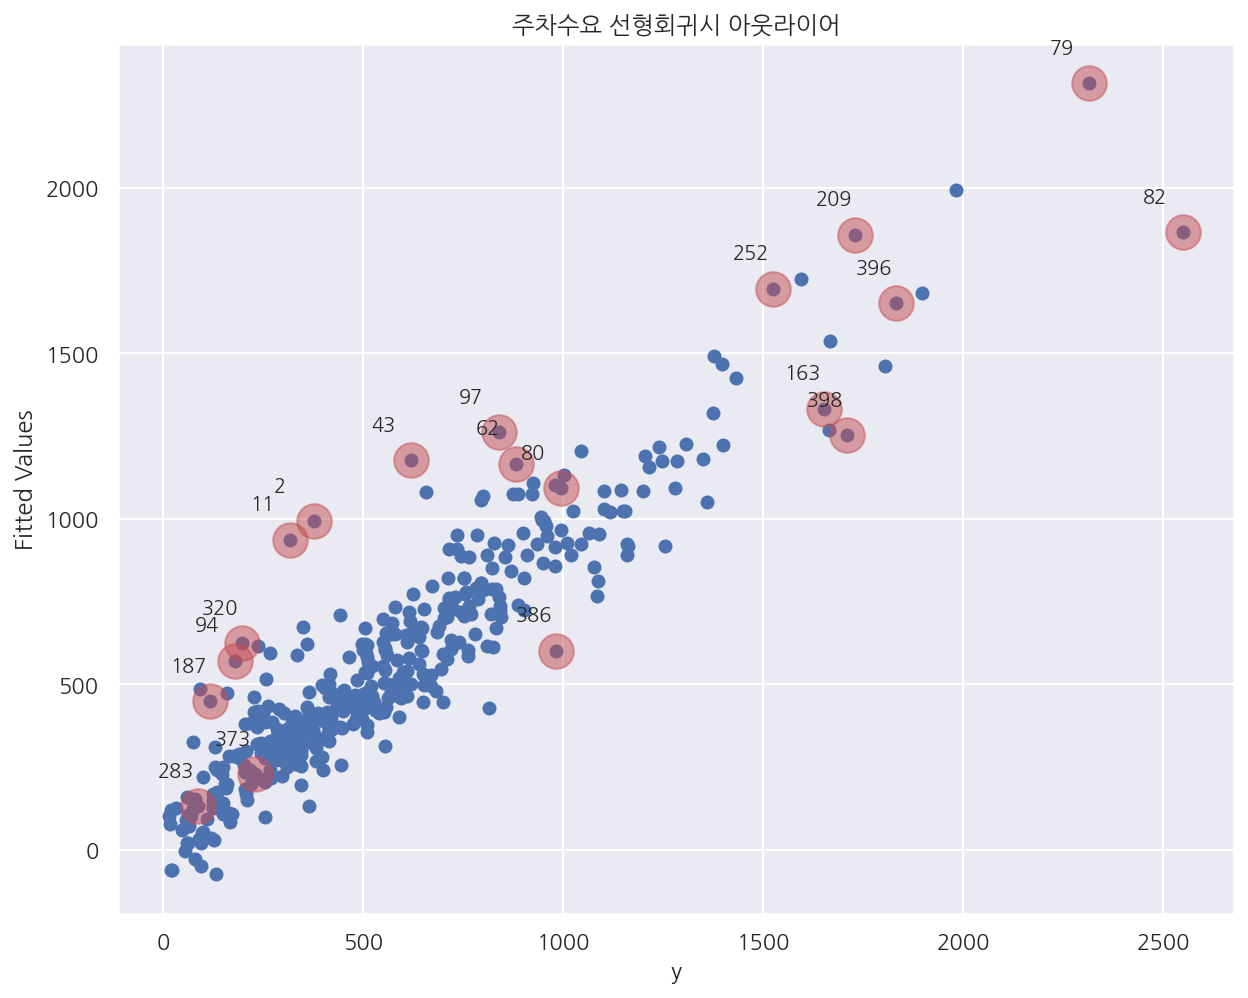

In [72]:
import statsmodels.api as sm
from statsmodels.graphics import utils


# 데이터 불러오기
dfX0 = final_train.copy().drop(columns="등록차량수")
dfX = sm.add_constant(dfX0)
dfy = final_train["등록차량수"].values

# 회귀모형 적합
model_sm = sm.OLS(dfy, dfX)
result_sm = model_sm.fit()
pred = result_sm.predict(dfX)        # 예측값

# 영향력 확인: 쿡의 거리
influence_sm = result_sm.get_influence()
cooks_d2, pvals = influence_sm.cooks_distance

n = len(dfy)
k = influence_sm.k_vars              # 모수의 수
fox_cr = 4 / (n - k - 1)             # Fox's Criteria
idx = np.where(cooks_d2 > fox_cr)[0] # 이상값, 레버리지 인덱스

ax = plt.subplot()

plt.scatter(dfy, pred)
plt.scatter(dfy[idx], pred[idx], s=300, c="r", alpha=0.5)

utils.annotate_axes(range(len(idx)), idx,
                    list(zip(dfy[idx], pred[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)

plt.xlabel("y")
plt.ylabel("Fitted Values")
plt.title("주차수요 선형회귀시 아웃라이어")

plt.show()

- 나는 ElasticNet을 선택하였었고 피처 선택의 기능도 일부 있고 조건수에 대한 문제는 없다고 생각했다.


- 그래서 컬럼 대신 인덱스를 기준으로 레버리지와 이상값을 확인하여 제거해보기로 생각했다.


- 위 코드는 단순선형회귀에서 쿡의 거리를 사용해 아웃라이어 인덱스를 추출한다.


- 여기서 추출한 인덱스를 제거하고 같은 ElasticNet으로 제출시에 MAE가 1정도 낮게 나타났었다.

### 1.5.4 스태킹 앙상블

In [73]:
# 개별 모델별 메타 데이터
def get_stacking_base_datasets(model, X_train, y_train, X_test, n_folds=5):
    # kfold 정의
    kfold = KFold(n_splits = n_folds, shuffle = True, random_state = 42)
    
    # 메타 데이터 반환을 위한 기본 배열
    train_cnt = X_train.shape[0]
    test_cnt = X_test.shape[0]
    train_meta = np.zeros((train_cnt, 1))
    test_meta = np.zeros((test_cnt, n_folds))
    
    # train 데이터를 기반으로 fold를 나눠 학습/예측
    for i , (train_fold_idx, test_fold_index) in enumerate(kfold.split(X_train)):
        # train, test fold 생성
        x_train_fold = X_train[train_fold_idx] 
        y_train_fold = y_train[train_fold_idx] 
        x_test_fold = X_train[test_fold_index]  
        
        # train_fold로 학습
        model.fit(x_train_fold , y_train_fold)       
        
        # train 메타 데이터 생성 (x_test_fold 예측)
        train_meta[test_fold_index, :] = model.predict(x_test_fold).reshape(-1,1)
        
        # test 메타 데이터 생성 (x_test 예측) - 평균 전
        test_meta[:, i] = model.predict(X_test)
            
    # test 메타 데이터 생성 - 평균 진행
    test_meta_mean = np.mean(test_meta, axis=1).reshape(-1,1)    
    
    # train test 메타 데이터 반환
    return train_meta , test_meta_mean

- 1.5.3까지의 과정으로 내 등수는 전체 440명 중 120등 정도로 나타났었다.


- 더 발전시킬 수 없을까 고민하다가 스태킹 앙상블 모델을 사용했다.


- [머신러닝 완벽가이드 스태킹 앙상블](https://romg2.github.io/mlguide/06_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C-04.-%EB%B6%84%EB%A5%98-%EC%8A%A4%ED%83%9C%ED%82%B9-%EC%95%99%EC%83%81%EB%B8%94/)에서 정리한 적이 있어 이를 활용했다.

In [74]:
from sklearn.model_selection import train_test_split

# 모든 변수 사용
X_feature = final_train.copy().drop(columns="등록차량수")
y_target = final_train["등록차량수"]
X_test = final_test.copy()

# 데이터 프레임, 시리즈 -> Numpy 배열
X_train = X_feature.values
X_test = X_test.values
y_train = y_target.values

# 각 모델 학습
lr_reg = LinearRegression()
ridge_reg = Ridge()
lasso_reg = Lasso()
elastic_reg = ElasticNet()

# 각 모델 메타 데이터
lr_train, lr_test = get_stacking_base_datasets(lr_reg, X_train, y_train, X_test)
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train, y_train, X_test)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train, y_train, X_test)
elastic_train, elastic_test = get_stacking_base_datasets(elastic_reg, X_train, y_train, X_test)

- 메타 데이터를 생성하기 위한 모델은 4개의 선형회귀모델을 사용하였다.


- 솔직히 말하면 이에 대한 논리는 사실 없으며... 시도에 의의를 뒀다.


- 다만 여기까지 과정에서 회귀 트리보다는 선형 회귀가 좋다고 판단해서 이렇게 만들었다.

In [75]:
# 최종 메타 데이터 결합
final_X_train_meta = np.concatenate((lr_train, ridge_train, lasso_train, elastic_train), axis=1)
final_X_test_meta = np.concatenate((lr_test, ridge_test, lasso_test, elastic_test), axis=1)

# 최종 메타 모델 학습/예측
# meta_model_lasso = Lasso()
# meta_model_lasso.fit(final_X_train_meta, y_train)
# meta_predict = meta_model_lasso.predict(final_X_test_meta)

# 평가 (test target 없으므로 평가 불가) - > 대신 다시 meta_train과 meta_test로 교차검증
# mae = mean_absolute_error(my_predict, meta_predict)
# print(f"스태킹 회귀 모델 MAE: {mae:.4f}")

# --------------------------------------------------------------------------------------------

# RandomForestRegressor, XGBRegressor, LGBMRegressor
rf_reg = RandomForestRegressor(random_state=42)
xgb_reg = XGBRegressor(random_state=42)
lgbm_reg = LGBMRegressor(random_state=42)

# LinearRegression, Ridge, Lasso, ElasticNet
lr_reg = LinearRegression()
ridge_reg = Ridge()
lasso_reg = Lasso()
elastic_reg = ElasticNet()

# 모델 객체 리스트
models = [rf_reg, xgb_reg, lgbm_reg, lr_reg, ridge_reg, lasso_reg, elastic_reg]

# 교차 검증
get_model_cv_prediction(models, final_X_train_meta, y_train)

,MAE_1,MAE_2,MAE_3,MAE_4,MAE_5,AVG_MAE,AVG_MAPE,MAE_Rank,MAPE_Rank
Model,,,,,,,,,
LinearRegression,117.80,117.07,136.06,95.71,127.78,118.88,37.32,1.0,1.0
Ridge,117.80,117.07,136.06,95.71,127.78,118.88,37.32,1.0,1.0
Lasso,118.88,118.49,135.88,96.26,127.74,119.45,37.81,3.0,5.0
ElasticNet,118.88,118.49,135.88,96.25,127.74,119.45,37.81,3.0,5.0
LGBMRegressor,122.10,121.84,131.00,116.84,140.12,126.38,37.56,5.0,3.0
RandomForestRegressor,117.73,121.30,148.32,118.46,163.46,133.85,38.37,6.0,7.0
XGBRegressor,130.20,119.21,142.67,130.34,157.12,135.91,37.67,7.0,4.0


- 여기선 교차검증 결과가 고만고만한데 내가 전처리한 버전에서도 그랬다.


- 다만 그냥 제출은 해보았는데 예측 성능은 크게 저하되었다.


- 솔직히 근거가 부족한채 시도한 것이니 그럴 수 밖에..

### 1.5.5 pycaret

In [76]:
reg = setup(final_train, 
            preprocess = False, # True로 설정되면, 자체적인 Feature Engineering을 추가로 진행해 Predict가 불가능해진다.
            train_size = 0.999,  # 우리는 전체 데이터를 학습해 test를 예측하는게 목표이기 때문에, 0.999로 설정한다.
            target = '등록차량수', # 목표 변수는 등록 차량 수 이다.
            silent = True, # 엔터를 누르기 귀찮다. 궁금하면 풀어보세요
            use_gpu = False, # GPU가 있으면 사용하세요 (Cat BOost 속도 향상)
            numeric_features=list(final_train.drop(columns = ['등록차량수']).columns), # 모든 변수가 숫자로써의 의미가 있다.
            session_id = 2021,
            fold_shuffle = True,
            fold = 5
            )

,Description,Value
0,session_id,2021
1,Target,등록차량수
2,Original Data,"(414, 71)"
3,Missing Values,False
4,Numeric Features,70
5,Categorical Features,0
6,Transformed Train Set,"(413, 70)"
7,Transformed Test Set,"(1, 70)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


- `pycaret` 패키지에 대해서는 사실 대회 전에 아예 몰랐다.


- 역시 코드 공유를 해주신 분 중에 한 분이 사용하여서 적용해보았다.


- 간략하게 말하면 Auto ML이라 하여 정말 간편하게 머신러닝 알고리즘을 비교할 수 있다.


- 다만 기존 모델들도 잘 모르는채 Auto ML을 사용하긴 그러니 사이킷런부터 잘 공부할 필요가 있어보인다.

In [77]:
top5 = compare_models(n_select = 5, sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,115.3960,31378.6321,175.2310,0.7969,0.3781,0.3110,0.0220
br,Bayesian Ridge,116.4981,30173.4206,171.5853,0.8046,0.3979,0.3328,0.0100
en,Elastic Net,117.3078,31061.4598,173.7949,0.7989,0.4234,0.3383,0.0140
lasso,Lasso Regression,117.7470,30701.2867,172.8898,0.8013,0.4755,0.3800,0.6820
llar,Lasso Least Angle Regression,118.8681,30887.8080,173.7532,0.8004,0.4098,0.3758,0.0140
ridge,Ridge Regression,120.5049,30749.5082,173.4145,0.8006,0.5401,0.4193,0.0080
lr,Linear Regression,120.5606,31239.3352,174.8740,0.7974,0.5411,0.4268,0.9920
catboost,CatBoost Regressor,121.1781,35326.1652,186.5193,0.7688,0.4044,0.3544,2.4480
omp,Orthogonal Matching Pursuit,122.1022,32168.3531,177.1473,0.7919,0.5238,0.3636,0.0080
gbr,Gradient Boosting Regressor,123.7817,33592.8381,182.3226,0.7792,0.4072,0.3619,0.0700


- 위와 같이 여러 머신러닝 알고리즘을 코드 한 줄로 간단하게 비교한다.


- 여기서 나오는 HuberRegressor에 대해 사실 잘 몰라서 사용하지는 않았다.


- 처음에 이거 보고 내가 고민하면서 교차검증 코드 짜두었는데 이렇게 간단히 나오다니.. 하고 한숨 쉬었다.

### 1.5.6 Catboost

In [78]:
X = final_train.drop(columns = ['등록차량수'])
y = final_train['등록차량수']
X_test = final_test.copy()

In [79]:
def objective(trial: Trial) -> float:
    params_cat = {
        "random_state": 42,
        "learning_rate": 0.05,
        "n_estimators": 10000,
        "verbose" : 1,
        "objective" : "MAE",
        "max_depth": trial.suggest_int("max_depth", 1, 16),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.8, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2)

    model = CatBoostRegressor(**params_cat)
    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        early_stopping_rounds=10,
        verbose=False,
    )

    cat_pred = model.predict(X_val)
    log_score = mean_absolute_error(y_val, cat_pred)
    
    return log_score

In [80]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="cat_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2021-08-12 00:35:10,705] A new study created in memory with name: cat_opt
[I 2021-08-12 00:35:12,268] Trial 0 finished with value: 92.24671653337226 and parameters: {'max_depth': 6, 'colsample_bylevel': 0.9901428612819833, 'subsample': 0.8123957592679836, 'min_child_samples': 62, 'max_bin': 246}. Best is trial 0 with value: 92.24671653337226.
[I 2021-08-12 00:35:12,784] Trial 1 finished with value: 109.8821593598015 and parameters: {'max_depth': 3, 'colsample_bylevel': 0.8116167224336399, 'subsample': 0.9063233020424546, 'min_child_samples': 62, 'max_bin': 413}. Best is trial 0 with value: 92.24671653337226.
[I 2021-08-12 00:35:13,171] Trial 2 finished with value: 109.31221155027754 and parameters: {'max_depth': 1, 'colsample_bylevel': 0.9939819704323989, 'subsample': 0.8827098485602951, 'min_child_samples': 25, 'max_bin': 254}. Best is trial 0 with value: 92.24671653337226.
[I 2021-08-12 00:35:13,668] Trial 3 finished with value: 154.1296660512618 and parameters: {'max_depth': 3, '

Best Score: 92.24671653337226
Best trial: {'max_depth': 6, 'colsample_bylevel': 0.9901428612819833, 'subsample': 0.8123957592679836, 'min_child_samples': 62, 'max_bin': 246}


- 위 코드 역시 코드 공유를 그대로 긁어온 것으로 내가 만든 건 아니다.


- `optuna` 패키지를 이용해서 train을 나눠 validation에 대한 성능을 기준으로 Catboost 모델을 튜닝하였다.


- 여기서 설정한 파라미터에 따라 컬럼과 인덱스의 비율이 정해지므로 굳이 피처 선택을 안해도 되겠다 싶었다.

In [81]:
# 앞서 확인한 파라미터 적용
cat_p = study.best_trial.params
cat = CatBoostRegressor(**cat_p)

In [82]:
# 모든 변수 사용
X_feature = final_train.copy().drop(columns="등록차량수")
y_target = final_train["등록차량수"]
X_test = final_test.copy()

cat.fit(X_feature, y_target, verbose=0)

In [83]:
# mae
mean_absolute_error(y_target, cat.predict(X_feature))

26.54546914274491

In [84]:
mean_absolute_percentage_error(y_target, cat.predict(X_feature))

9.188104655250816

- 여기서 train에 대한 예측 후 MAE를 확인하면 26, MAPE는 9% 정도로 나타난다.


- 앞서 교차검증에서 보통 110대로 나타났는데 아무리 train 예측이라지만 너무 낮게 나타났다.


- 물론 위 코드에서 objective 함수를 정의할 때 `train_test_split()` 함수에 시드를 설정하지 않아 결과는 달라진다.


- 아무튼 교차검증에서 catboost 역시 MAE가 100이 훌쩍 넘었는데 이해가 안되서 확인해보았다.


- 확인해보니 트리 계열 모델들은 회귀 모델에 비해 아무 튜닝없이 그냥 학습만 시켜도 train에 너무 과적합되어 나타났다.


- 그래서 위 코드도 사실 `train_test_split()`을 이용해서 과적합을 피하기 위한 파라미터를 찾는 방법이다.

## 1.6 제출

In [85]:
# 모든 변수 사용
X_feature = final_train.copy().drop(columns="등록차량수")
y_target = final_train["등록차량수"]
X_test = final_test.copy()

# 모델 객체 생성
# 최적 하이퍼 파라미터: {'alpha': 0.1, 'l1_ratio': 0.1, 'max_iter': 100}
elastic_reg = ElasticNet(alpha=0.1, l1_ratio=0.1, max_iter=100)

# 학습
elastic_reg.fit(X_feature, y_target)

# 예측
my_predict = elastic_reg.predict(X_test)

# 교차 검증
get_model_cv_prediction([elastic_reg], X_feature, y_target)

,MAE_1,MAE_2,MAE_3,MAE_4,MAE_5,AVG_MAE,AVG_MAPE,MAE_Rank,MAPE_Rank
Model,,,,,,,,,
ElasticNet,114.94,118.75,138.3,95.74,121.79,117.9,34.35,1.0,1.0


In [86]:
# 예측 데이터 프레임
predict_df = final_test.reset_index()[["단지코드"]]
predict_df["predict"] = my_predict
predict_df.head()

,단지코드,predict
0,C1003,215.515024
1,C1006,239.713304
2,C1016,704.580005
3,C1019,272.046292
4,C1030,37.036826


In [87]:
# 제출 파일 내보내기
temp = pd.merge(submission, predict_df, left_on="code", right_on="단지코드", how="left")
temp["num"] = temp["predict"]
my_submission = temp[["code","num"]].fillna(0)

# 저장할 때만 사용
# my_submission.to_csv('제출파일/predict_28.csv', index=False)

- 제출 코드는 특별한 것은 없고 train, test를 단지코드 순으로 정렬하였기에 `pd.merge()`를 사용하였다.

## 1.7 EOD

여기까지 내가 한 달간 작업했던 내용에 대해 정리해보았다. 위 내용 외에도 target과 상관관계가 높은 피처의 분포를 확인하고 서브셋을 나눠 각각 다른 모델을 적용도 해보았고 더 많은 시도를 해보았던 것 같다. 다른 분이 train의 target 정보를 test에 심어준 것을 보고 어떠한 논리로 사용하셨는지 고민해보고 그 분이 당시 60등 정도여서 내가 그동안 너무 편견이 있었나 싶기도 했었다.

그리고 나의 결과에 대해서 말하자면 511팀 중 public에선 80등, private에선 151등으로 마무리했다. 여기선 자세히 다루지 않았지만 train과 test의 분포가 많이 달랐고 애초에 제출시에는 test 150개 단지 중 50 단지에 대한 MAE만 확인할 수 있다. 그러니 더더욱 과적합에 유의하여야 한다. 당연히 이 생각도 하였고 최대한 train과 test를 비슷한 구조로 전처리하고 train에 대한 교차검증 성능을 높이는 방향으로 결정하였는데 아무래도 public 등수에 집착하게 되었다. 교차검증 결과는 더 안좋은 모델인데 public 등수는 더 높아지기도 하면서 혼란이 많이 왔다. 나름 전처리를 최대한 맞췄다고 생각했는데 이런 결과가 나타나니 어떻게 손봐야할까 싶기도 했다. 처음부터 엎자니 마감시간이 얼마 남지도 않아 결국 public 점수가 제일 좋은 모델로 최종 제출하였는데 등수가 확 떨어졌다. 

이번 대회는 단지코드 레벨로 전처리시 train과 test의 데이터가 너무 적기도 하였고 실제 public의 상위권 분들은 private에서 등수가 많이 떨어져 다른 대회에 비해서 등수변동이 정말 심하였다. 물론 이런 상황을 감안해서 생각하여야지만 아무래도 처음 도전한 대회다 보니 힘들기도 하였다. 대신 이 경험으로 배운게 많으니 다음 대회에 도전하면 더 재밌게 잘 할 수 있을 것 같다.